### Table of Contents

* [1 BANK ENTITY RELATIONSHIP DIAGRAM](#BANKENTITYRELATIONSHIPDIAGRAM)
* [2 IMPORT DATA](#IMPORTDATA)
    * [2.1 Transaction Data](#TransactionData_2_1)
    * [2.2 Account Data](#AccountData_2_2)
    * [2.3 Account Balance Data](#AccountBalanceData_2_3)
    * [2.4 Income Data](#IncomeData_2_4)
    * [2.5 Spending Data](#SpendingData_2_5)
    * [2.6 Transaction = Account + Income + Spending + Balance](#Transaction=Account+Income+Spending+Balance_2_6)
    * [2.7 Loan Data](#LoanData_2_7)
    * [2.8 Order Data](#OrderData_2_8)
    * [2.9 Card Data](#CardData_2_9)
    * [2.10 District / Demography Data](#District/DemographyData_2_10)
    * [2.11 Client Data](#ClientData_2_11)
* [3 DATA WRANGLING](#DATAWRANGLING)
* [4 ENCODING](#ENCODING)
    * [4.1 Define Target Variable](#DefineTargetVariable_4_1)
* [5 EXPLORATORY DATA ANALYSIS](#EXPLORATORYDATAANALYSIS)
* [6 FEATURE SELECTION AND ENGINEERING](#FEATURESELECTIONANDENGINEERING)
    * [6.1 Step 1: Filter Method](#Step1:FilterMethod_6_1)
    * [6.2 Step 2](#Step2_6_2)
    * [6.3 Step 3](#Step3_6_3)
* [7 UNSUPERVISED MACHINE LEARNING MODELLING](#UNSUPERVISEDMACHINELEARNINGMODELLING)
    * [7.1 K-Means Clustering](#K-MeansClustering_7_1)

### BANK ENTITY RELATIONSHIP DIAGRAM <a class="anchor" id="BANKENTITYRELATIONSHIPDIAGRAM"></a>

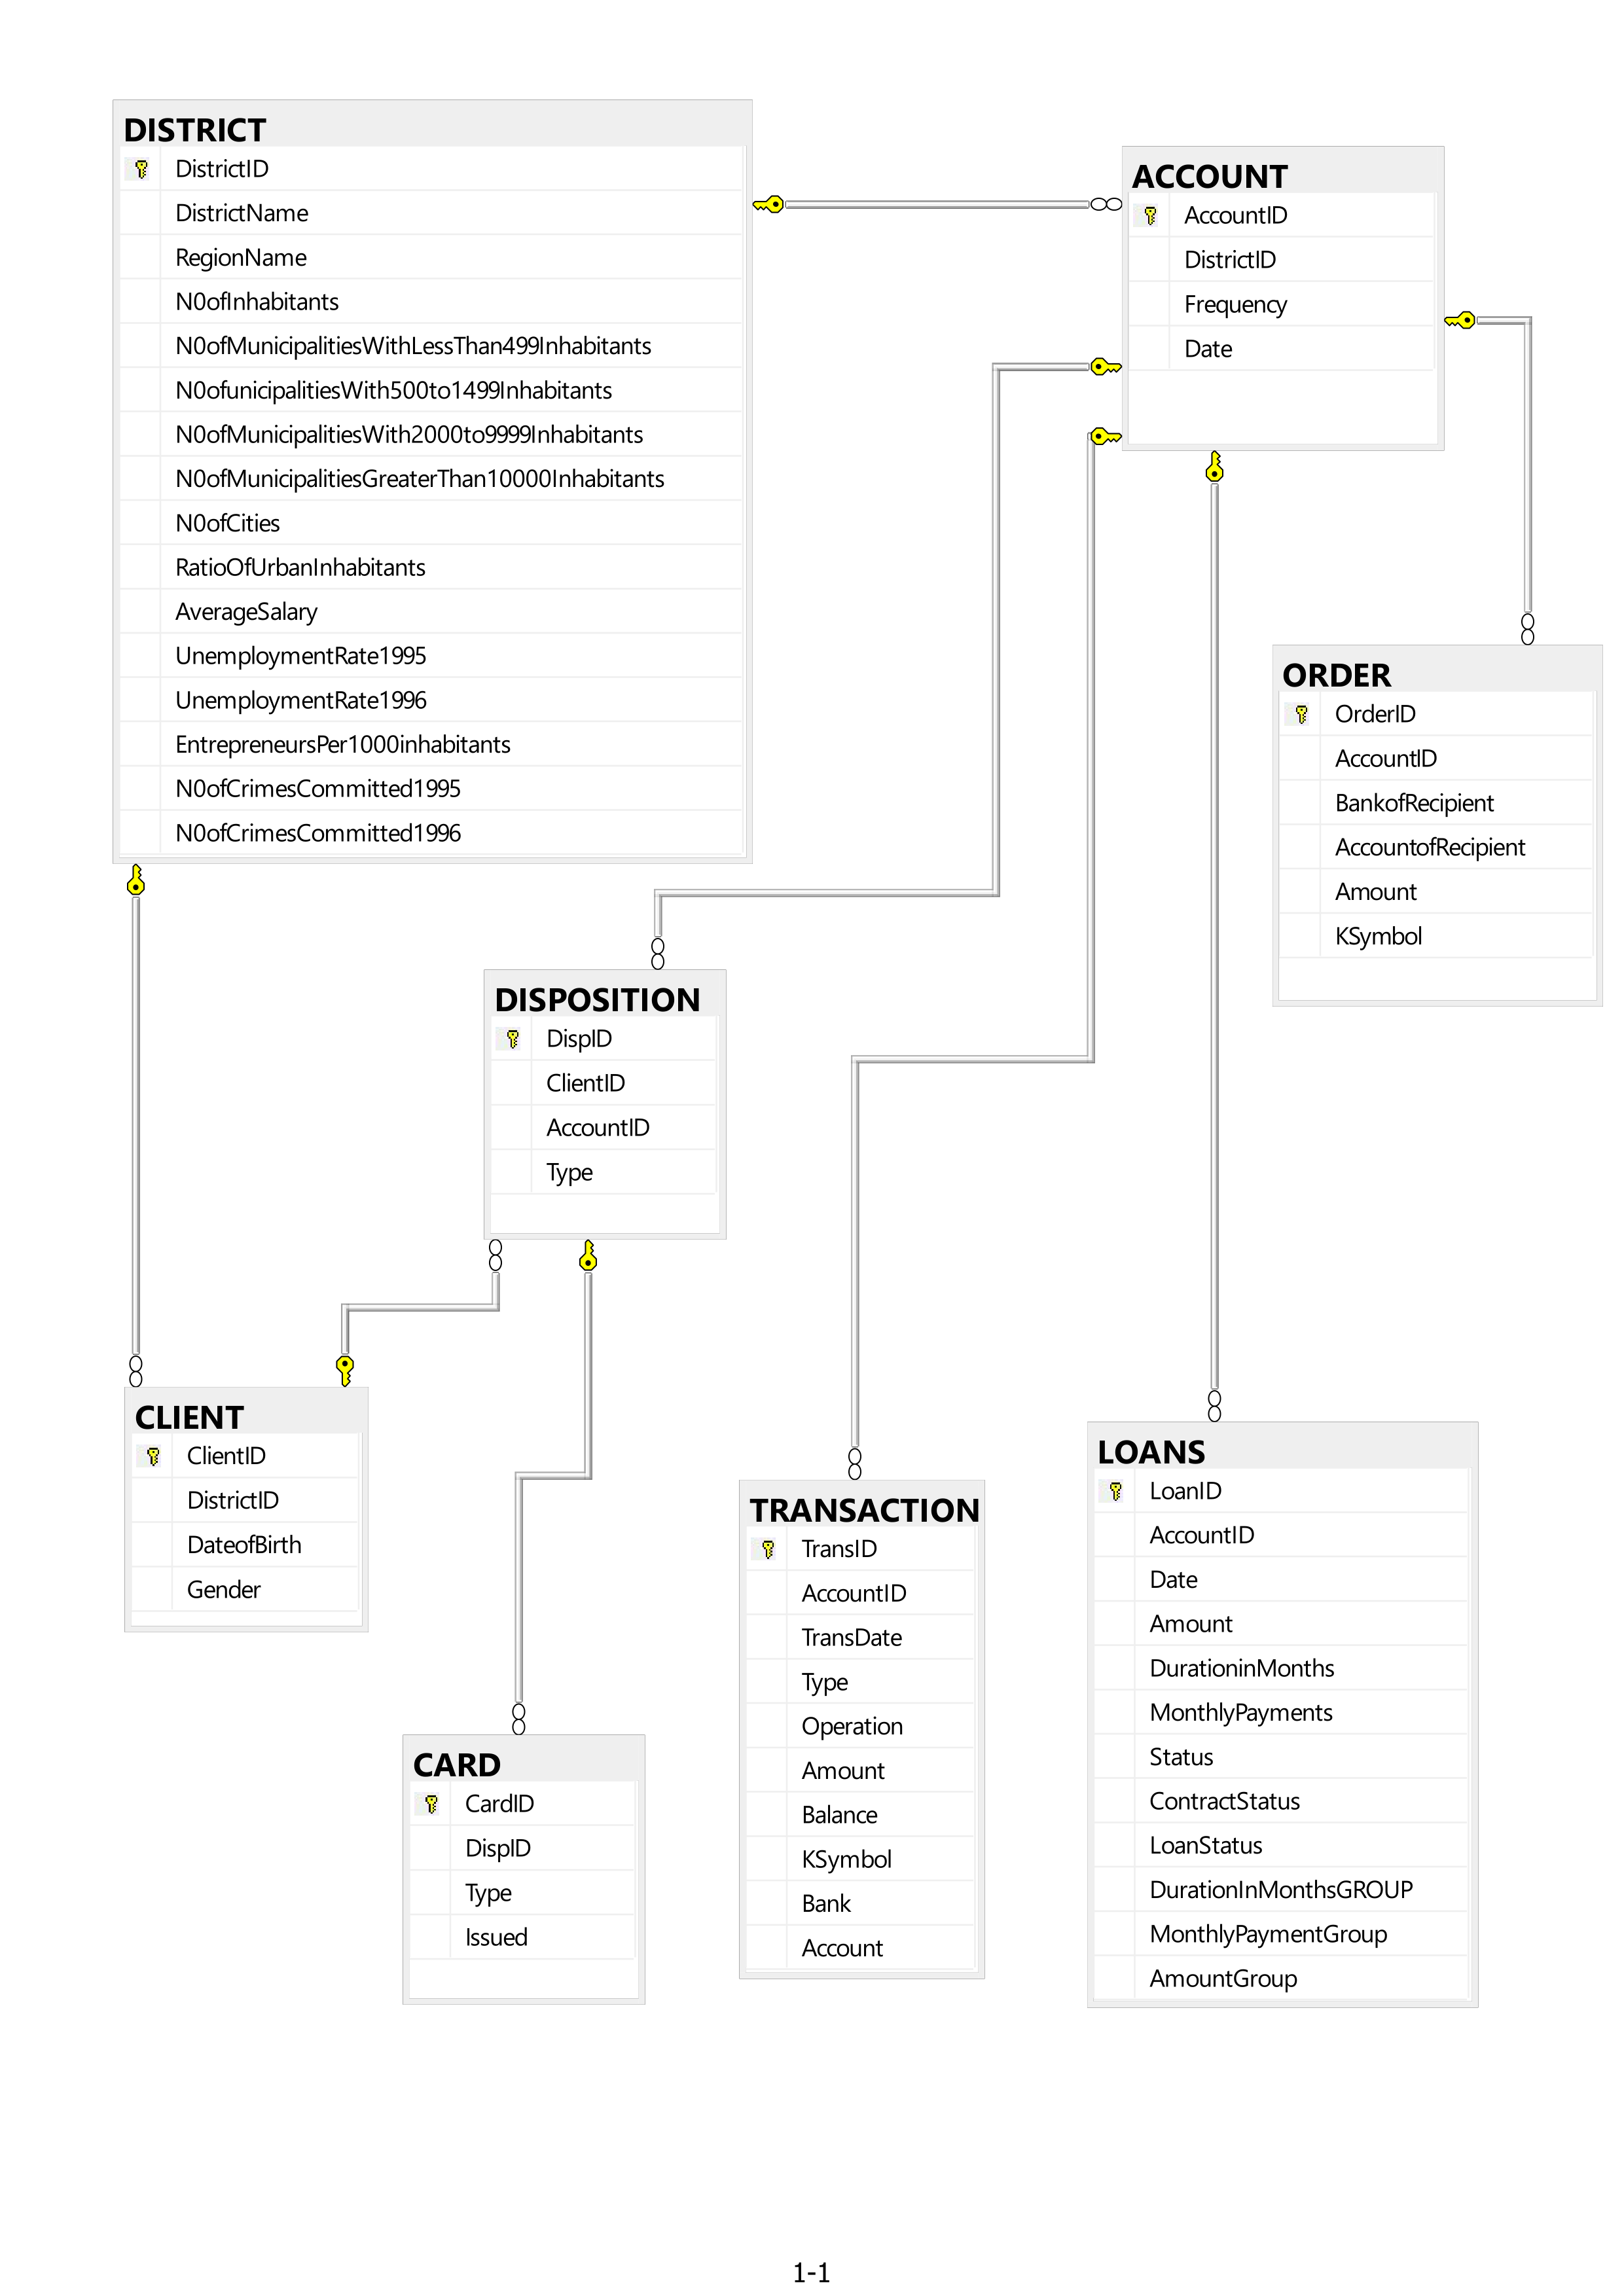

## IMPORT DATA <a class="anchor" id="IMPORTDATA"></a>

In [1]:
# Standard libraries for data analysis:
    
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc
import scipy.sparse as sparse
from scipy.stats import norm, skew
from scipy import stats
from scipy.sparse.linalg import spsolve
import statsmodels.api as sm

# sklearn modules for data preprocessing:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

# sklearn modules for Model Selection:

from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# sklearn modules for Model Evaluation & Improvement:
    
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score

# Standard libraries for data visualization:

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sns.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pylab import rcParams
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve
from pandas.plotting import register_matplotlib_converters

# Miscellaneous Utilitiy Libraries:
    
import random
import os
import re
import sys
import timeit
import string
import time
from datetime import datetime
from time import time
from dateutil.parser import parse
from dateutil import relativedelta
import joblib

%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LAPTOP-OA139RT5;'
                      'Database=Czech bank;'
                      'Trusted_Connection=yes;')

### Transaction Data <a class="anchor" id="TransactionData_2_1"></a>

In [3]:
TRANS_data= pd.read_sql_query("""
SELECT *

FROM [dbo].[TRANSACTION]
""", conn)

TRANS_data.head()

,TransID,AccountID,TransDate,Type,Operation,Amount,Balance,KSymbol,Bank,Account
0,1,1,1995-03-24,Credit,Credit in cash,1000.0,1000.0,,,NaN
1,5,1,1995-04-13,Credit,Collection from another bank,3679.0,4679.0,,AB,41403269.0
2,6,1,1995-05-13,Credit,Collection from another bank,3679.0,20977.2,,AB,41403269.0
3,7,1,1995-06-13,Credit,Collection from another bank,3679.0,26835.2,,AB,41403269.0
4,8,1,1995-07-13,Credit,Collection from another bank,3679.0,30414.8,,AB,41403269.0


In [4]:
TRANS_data.shape

(1056320, 10)

In [5]:
TRANS_data.isna().sum()

TransID           0
AccountID         0
TransDate         0
Type              0
Operation         0
Amount            0
Balance           0
KSymbol           0
Bank              0
Account      760931
dtype: int64

There's a lot missing/no data in columns (**KSymbol, Bank, Account**). We decided to ignore these columns as we are more focused on the account **Balance** column after each transaction.

In [6]:
# check for duplicate rows

Tr = TRANS_data.duplicated().any()

In [7]:
Tr

False

No duplicate rows found

### Account Data <a class="anchor" id="AccountData_2_2"></a>

In [8]:
ACCOUNT_data= pd.read_sql_query("""
SELECT
CL.ClientID
,MIN(AC.Date) AS Acc_Creation_Date

FROM [dbo].[ACCOUNT] AC

LEFT JOIN [dbo].[DISPOSITION] DIS

ON AC.AccountID = DIS.AccountID

LEFT JOIN [dbo].[CLIENT] CL

ON DIS.ClientID = CL.ClientID

GROUP BY CL.ClientID
""", conn)

ACCOUNT_data.head()

,ClientID,Acc_Creation_Date
0,1589,1993-12-03
1,2253,1997-08-18
2,2917,1997-02-27
3,3581,1997-03-27
4,23,1997-01-08


### Account Balance Data <a class="anchor" id="AccountBalanceData_2_3"></a>

In [9]:
# Deriving total account balance for each customer

AccBal_data= pd.read_sql_query("""
SELECT
CL.ClientID
,SUM(TR.Balance) AS Acc_Balance
,MAX(TR.TransDate) AS Max_TransDate

FROM [dbo].[TRANSACTION] TR

LEFT JOIN [dbo].[ACCOUNT] AC

ON TR.AccountID = AC.AccountID

LEFT JOIN [dbo].[DISPOSITION] DIS

ON AC.AccountID = DIS.AccountID

LEFT JOIN [dbo].[CLIENT] CL

ON DIS.ClientID = CL.ClientID

GROUP BY CL.ClientID

ORDER BY AVG(TR.Balance)/COUNT(TR.TransID) DESC
""", conn)

AccBal_data.head()

,ClientID,Acc_Balance,Max_TransDate
0,872,241300.0,1998-11-20
1,3495,294400.0,1998-12-11
2,3496,294400.0,1998-12-11
3,1763,497500.0,1998-11-17
4,908,242000.0,1998-11-14


### Income Data <a class="anchor" id="IncomeData_2_4"></a>

In [10]:
# Deriving Income data for each customer

Income_data= pd.read_sql_query("""
SELECT
CL.ClientID
,SUM(TR.Amount) AS Income

FROM [dbo].[TRANSACTION] TR

LEFT JOIN [dbo].[ACCOUNT] AC

ON TR.AccountID = AC.AccountID

LEFT JOIN [dbo].[DISPOSITION] DIS

ON AC.AccountID = DIS.AccountID

LEFT JOIN [dbo].[CLIENT] CL

ON DIS.ClientID = CL.ClientID

GROUP BY CL.ClientID , TR.Type

HAVING TR.Type = 'Credit'

""", conn)

Income_data.head()

,ClientID,Income
0,1388,923168.8
1,1389,164497.7
2,1407,544113.3
3,1414,1085642.3
4,1441,152586.8


### Spending Data <a class="anchor" id="SpendingData_2_5"></a>

In [11]:
# Deriving Average Spending data for each customer

AvgSpending_data= pd.read_sql_query("""
SELECT
CL.ClientID
,AVG(TR.Amount) AS Avg_Spending

FROM [dbo].[TRANSACTION] TR

LEFT JOIN [dbo].[ACCOUNT] AC

ON TR.AccountID = AC.AccountID

LEFT JOIN [dbo].[DISPOSITION] DIS

ON AC.AccountID = DIS.AccountID

LEFT JOIN [dbo].[CLIENT] CL

ON DIS.ClientID = CL.ClientID

GROUP BY CL.ClientID , TR.Type

HAVING TR.Type = 'Withdrawal'

""", conn)

AvgSpending_data.head()

,ClientID,Avg_Spending
0,18,2215.7863
1,33,2702.2064
2,43,1343.6904
3,68,3287.3442
4,86,10883.3600


### Transaction = Account + Income + Spending + Balance <a class="anchor" id="Transaction=Account+Income+Spending+Balance_2_6"></a>

In [12]:
Transaction = AccBal_data.merge(Income_data)
Transaction.head()

,ClientID,Acc_Balance,Max_TransDate,Income
0,872,241300.0,1998-11-20,34000.0
1,3495,294400.0,1998-12-11,39300.0
2,3496,294400.0,1998-12-11,39300.0
3,1763,497500.0,1998-11-17,40100.0
4,908,242000.0,1998-11-14,34800.0


In [13]:
Transaction = Transaction.merge(AvgSpending_data)
Transaction.head()

,ClientID,Acc_Balance,Max_TransDate,Income,Avg_Spending
0,872,241300.0,1998-11-20,34000.0,700.0000
1,3495,294400.0,1998-12-11,39300.0,1400.0000
2,3496,294400.0,1998-12-11,39300.0,1400.0000
3,1763,497500.0,1998-11-17,40100.0,1633.3333
4,908,242000.0,1998-11-14,34800.0,2000.0000


In [14]:
Transaction = Transaction.merge(ACCOUNT_data)
Transaction.head()

,ClientID,Acc_Balance,Max_TransDate,Income,Avg_Spending,Acc_Creation_Date
0,872,241300.0,1998-11-20,34000.0,700.0000,1997-12-25
1,3495,294400.0,1998-12-11,39300.0,1400.0000,1997-12-16
2,3496,294400.0,1998-12-11,39300.0,1400.0000,1997-12-16
3,1763,497500.0,1998-11-17,40100.0,1633.3333,1997-07-25
4,908,242000.0,1998-11-14,34800.0,2000.0000,1997-12-19


In [15]:
Transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ClientID           5369 non-null   int64         
 1   Acc_Balance        5369 non-null   float64       
 2   Max_TransDate      5369 non-null   datetime64[ns]
 3   Income             5369 non-null   float64       
 4   Avg_Spending       5369 non-null   float64       
 5   Acc_Creation_Date  5369 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 293.6 KB


In [16]:
# Deriving Total_Days and Total_Months (Customer_Tenure) 

Transaction['Tenure_Days'] = Transaction['Max_TransDate']  - Transaction['Acc_Creation_Date'] # Tenure_Days in deltatime
Transaction['Tenure_Days'] = (Transaction['Tenure_Days']/ np.timedelta64(1, 'D')).astype(int) # Tenure_Days converted to int
Transaction['Tenure_Months'] = Transaction['Tenure_Days']/30.0 # convert days to months
    
Transaction.head()

,ClientID,Acc_Balance,Max_TransDate,Income,Avg_Spending,Acc_Creation_Date,Tenure_Days,Tenure_Months
0,872,241300.0,1998-11-20,34000.0,700.0000,1997-12-25,330,11.0
1,3495,294400.0,1998-12-11,39300.0,1400.0000,1997-12-16,360,12.0
2,3496,294400.0,1998-12-11,39300.0,1400.0000,1997-12-16,360,12.0
3,1763,497500.0,1998-11-17,40100.0,1633.3333,1997-07-25,480,16.0
4,908,242000.0,1998-11-14,34800.0,2000.0000,1997-12-19,330,11.0


In [17]:
# Deriving Monthly_Income & Monthly_Spending

Transaction['Monthly_Income'] = Transaction['Income']/Transaction['Tenure_Months']
Transaction['Avg_Monthly_Spending'] = Transaction['Avg_Spending']/Transaction['Tenure_Months']
Transaction['Daily_Balance'] = Transaction['Acc_Balance']/Transaction['Tenure_Days']

Transaction.head()

,ClientID,Acc_Balance,Max_TransDate,Income,Avg_Spending,Acc_Creation_Date,Tenure_Days,Tenure_Months,Monthly_Income,Avg_Monthly_Spending,Daily_Balance
0,872,241300.0,1998-11-20,34000.0,700.0000,1997-12-25,330,11.0,3090.909091,63.636364,731.212121
1,3495,294400.0,1998-12-11,39300.0,1400.0000,1997-12-16,360,12.0,3275.000000,116.666667,817.777778
2,3496,294400.0,1998-12-11,39300.0,1400.0000,1997-12-16,360,12.0,3275.000000,116.666667,817.777778
3,1763,497500.0,1998-11-17,40100.0,1633.3333,1997-07-25,480,16.0,2506.250000,102.083331,1036.458333
4,908,242000.0,1998-11-14,34800.0,2000.0000,1997-12-19,330,11.0,3163.636364,181.818182,733.333333


In [18]:
Transaction['Daily_Balance'].describe()

count     5369.000000
mean      7029.858862
std       3906.014140
min        211.176471
25%       3868.316461
50%       6388.536013
75%       9348.393120
max      26297.662332
Name: Daily_Balance, dtype: float64

In [19]:
Transaction = Transaction.drop(['Acc_Balance', 'Max_TransDate', 'Income', 'Avg_Spending', 'Acc_Creation_Date', 'Tenure_Days', 'Tenure_Months'], axis=1)
Transaction.head()

,ClientID,Monthly_Income,Avg_Monthly_Spending,Daily_Balance
0,872,3090.909091,63.636364,731.212121
1,3495,3275.000000,116.666667,817.777778
2,3496,3275.000000,116.666667,817.777778
3,1763,2506.250000,102.083331,1036.458333
4,908,3163.636364,181.818182,733.333333


### Loan Data <a class="anchor" id="LoanData_2_7"></a>

In [20]:
# Deriving Loan data for customers

Loan_data= pd.read_sql_query("""
SELECT
LN.LoanID
,CL.ClientID
,LN.ContractStatus
,LN.LoanStatus
,LN.Status
,LN.DurationinMonths
,LN.DurationInMonthsGROUP
,LN.Date AS Loan_Date

FROM [dbo].[LOANS] LN

LEFT JOIN [dbo].[ACCOUNT] AC

ON LN.AccountID = AC.AccountID

LEFT JOIN [dbo].[DISPOSITION] DIS

ON AC.AccountID = DIS.AccountID

LEFT JOIN [dbo].[CLIENT] CL

ON DIS.ClientID = CL.ClientID

""", conn)

Loan_data.head()

,LoanID,ClientID,ContractStatus,LoanStatus,Status,DurationinMonths,DurationInMonthsGROUP,Loan_Date
0,4959,2,Finished,No problems,A,24,0-30,1994-01-05
1,4959,3,Finished,No problems,A,24,0-30,1994-01-05
2,4961,25,Finished,Loan not payed,B,12,0-30,1996-04-29
3,4962,31,Finished,No problems,A,12,0-30,1997-12-08
4,4967,45,Running,Client in debt,D,60,55 above,1998-10-14


In [21]:
# check for missing values

Loan_data.isna().sum()

LoanID                   0
ClientID                 0
ContractStatus           0
LoanStatus               0
Status                   0
DurationinMonths         0
DurationInMonthsGROUP    0
Loan_Date                0
dtype: int64

In [22]:
# check for duplicates

doon = Loan_data.duplicated().any()
doon

False

No missing data & no duplicates in the Loan_data

In [23]:
# lets make today as the last day of transaction from the AccBal_data data

Today = AccBal_data['Max_TransDate'].max()
Today

Timestamp('1998-12-31 00:00:00')

In [24]:
# creating days loan issued and months left columns

Loan_data['Days_Loan_Issued'] = Today - Loan_data['Loan_Date']
Loan_data['Days_Loan_Issued'] = (Loan_data['Days_Loan_Issued']/ np.timedelta64(1, 'D')).astype(int)

Loan_data['Months_Left'] = Loan_data['DurationinMonths'] - (Loan_data['Days_Loan_Issued']/30)
    
Loan_data.head()

,LoanID,ClientID,ContractStatus,LoanStatus,Status,DurationinMonths,DurationInMonthsGROUP,Loan_Date,Days_Loan_Issued,Months_Left
0,4959,2,Finished,No problems,A,24,0-30,1994-01-05,1821,-36.700000
1,4959,3,Finished,No problems,A,24,0-30,1994-01-05,1821,-36.700000
2,4961,25,Finished,Loan not payed,B,12,0-30,1996-04-29,976,-20.533333
3,4962,31,Finished,No problems,A,12,0-30,1997-12-08,388,-0.933333
4,4967,45,Running,Client in debt,D,60,55 above,1998-10-14,78,57.400000


In [25]:
# Since Status "A" has Finished Contract and "No Problems" then Months_Left should be zero

Loan_data.loc[(Loan_data.Status == 'A'), ('Months_Left')] = 0
Loan_data.head()

,LoanID,ClientID,ContractStatus,LoanStatus,Status,DurationinMonths,DurationInMonthsGROUP,Loan_Date,Days_Loan_Issued,Months_Left
0,4959,2,Finished,No problems,A,24,0-30,1994-01-05,1821,0.000000
1,4959,3,Finished,No problems,A,24,0-30,1994-01-05,1821,0.000000
2,4961,25,Finished,Loan not payed,B,12,0-30,1996-04-29,976,-20.533333
3,4962,31,Finished,No problems,A,12,0-30,1997-12-08,388,0.000000
4,4967,45,Running,Client in debt,D,60,55 above,1998-10-14,78,57.400000


### Order Data <a class="anchor" id="OrderData_2_8"></a>

In [26]:
# Importing Order data for customers

Order_data= pd.read_sql_query("""
SELECT
CL.ClientID
,ORD.OrderID
,ORD.Amount AS Order_Amount
,ORD.KSymbol AS Order_Type

FROM [dbo].[ORDER] ORD

LEFT JOIN [dbo].[ACCOUNT] AC

ON ORD.AccountID = AC.AccountID

LEFT JOIN [dbo].[DISPOSITION] DIS

ON AC.AccountID = DIS.AccountID

LEFT JOIN [dbo].[CLIENT] CL

ON DIS.ClientID = CL.ClientID

""", conn)

Order_data.head()

,ClientID,OrderID,Order_Amount,Order_Type
0,1,29401,2452.0,Household (H)
1,2,29402,3372.7,Loan Payment (LP)
2,3,29402,3372.7,Loan Payment (LP)
3,2,29403,7266.0,Household (H)
4,3,29403,7266.0,Household (H)


In [27]:
# creating a column for each Order_Type whose value is the amount of the order

Order_data = Order_data.groupby(['ClientID', 'Order_Type'])['Order_Amount'].sum().unstack().reset_index().fillna(0)
Order_data.rename(columns = {' ':'Unknown' , 'Leasing (H)':'Leasing (L)'}, inplace = True)

Order_data.head()

Order_Type,ClientID,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP)
0,1,0.0,2452.0,0.0,0.0,0.0
1,2,0.0,7266.0,0.0,0.0,3372.7
2,3,0.0,7266.0,0.0,0.0,3372.7
3,4,327.0,1135.0,3539.0,0.0,0.0
4,5,327.0,1135.0,3539.0,0.0,0.0


In [28]:
# check for missing values

Order_data.isna().sum()

Order_Type
ClientID                  0
Unknown                   0
Household (H)             0
Insurance Payment (IP)    0
Leasing (L)               0
Loan Payment (LP)         0
dtype: int64

In [29]:
# check for duplicates

doon = Order_data.duplicated().any()
doon

False

No duplicates nor missing values found in Order_data

### Card Data <a class="anchor" id="CardData_2_9"></a>

In [30]:
# Importing Order data for customers

Card_data= pd.read_sql_query("""
SELECT
CR.CardID
,CL.ClientID
,CR.Type AS Card_Type
,CR.Issued AS Date_Issued

FROM [dbo].[CARD] CR

LEFT JOIN [dbo].[DISPOSITION] DIS

ON CR.DispID = DIS.DispID

LEFT JOIN [dbo].[CLIENT] CL

ON DIS.ClientID = CL.ClientID

""", conn)

Card_data.head()

,CardID,ClientID,Card_Type,Date_Issued
0,1,9,gold,1998-10-16
1,2,19,classic,1998-03-13
2,3,41,gold,1995-09-03
3,4,42,classic,1998-11-26
4,5,51,junior,1995-04-24


In [31]:
Card_data['Date_Issued'].max()

Timestamp('1998-12-29 00:00:00')

In [32]:
# creating days card issued column

Card_data['Days_Card_Issued'] = Today - Card_data['Date_Issued']
Card_data['Days_Card_Issued'] = (Card_data['Days_Card_Issued']/ np.timedelta64(1, 'D')).astype(int) # converts timedelta to int
Card_data.head()

,CardID,ClientID,Card_Type,Date_Issued,Days_Card_Issued
0,1,9,gold,1998-10-16,76
1,2,19,classic,1998-03-13,293
2,3,41,gold,1995-09-03,1215
3,4,42,classic,1998-11-26,35
4,5,51,junior,1995-04-24,1347


In [33]:
# check for missing data

Card_data.isna().sum()

CardID              0
ClientID            0
Card_Type           0
Date_Issued         0
Days_Card_Issued    0
dtype: int64

In [34]:
# check for duplicates

doon = Card_data.duplicated().any()
doon

False

No duplicates nor missing values found in Card_data

### District / Demography Data <a class="anchor" id="District/DemographyData_2_10"></a>

In [35]:
# Importing Demograhy data for customers

District_data= pd.read_sql_query("""
SELECT
CL.ClientID
,DST.DistrictName
,DST.RegionName
,DST.N0ofInhabitants
,DST.N0ofCities
,DST.RatioOfUrbanInhabitants
,DST.AverageSalary
,DST.UnemploymentRate1995
,DST.UnemploymentRate1996
,DST.EntrepreneursPer1000inhabitants
,DST.N0ofCrimesCommitted1995
,DST.N0ofCrimesCommitted1996

FROM [dbo].[DISTRICT] DST

LEFT JOIN [dbo].[CLIENT] CL

ON DST.DistrictID = CL.DistrictID

""", conn)

District_data.head()

,ClientID,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996
0,1,Pisek,south Bohemia,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910
1,2,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107
2,3,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107
3,4,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040
4,5,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040


In [36]:
# check for missing data

District_data.isna().sum()

ClientID                           0
DistrictName                       0
RegionName                         0
N0ofInhabitants                    0
N0ofCities                         0
RatioOfUrbanInhabitants            0
AverageSalary                      0
UnemploymentRate1995               0
UnemploymentRate1996               0
EntrepreneursPer1000inhabitants    0
N0ofCrimesCommitted1995            0
N0ofCrimesCommitted1996            0
dtype: int64

In [37]:
# check for duplicates

doon = District_data.duplicated().any()
doon

False

No duplicates nor missing values found in District_data

### Client Data <a class="anchor" id="ClientData_2_11"></a>

In [38]:
# Importing Client data

Client_data= pd.read_sql_query("""
SELECT
[ClientID]
,[DateofBirth]
,[Gender]

FROM [dbo].[CLIENT]

""", conn)

Client_data.head()

,ClientID,DateofBirth,Gender
0,1,1970-12-13,Female
1,2,1945-02-04,Male
2,3,1940-10-09,Female
3,4,1956-12-01,Male
4,5,1960-07-03,Female


In [39]:
# Deriving Age and Age groups from DateofBirth column

Client_data['Age'] = Client_data["DateofBirth"].apply(lambda x : (Today.year - x.year))

Client_data['Age Group'] = 'Between 24 to 65 Years'
Client_data.loc[Client_data['Age'] >64,'Age Group'] = 'Senior' 
Client_data.loc[Client_data['Age'] <= 64,'Age Group'] = 'Middle- Aged'
Client_data.loc[Client_data['Age'] <= 35,'Age Group'] = 'Adult'
Client_data.loc[Client_data['Age'] <= 24,'Age Group'] = 'Youth'

Client_data.head()

,ClientID,DateofBirth,Gender,Age,Age Group
0,1,1970-12-13,Female,28,Adult
1,2,1945-02-04,Male,53,Middle- Aged
2,3,1940-10-09,Female,58,Middle- Aged
3,4,1956-12-01,Male,42,Middle- Aged
4,5,1960-07-03,Female,38,Middle- Aged


In [40]:
# drop DateofBirth column since we have Age

Client_data.drop(['DateofBirth'], axis=1, inplace = True)

In [41]:
# check for missing data

Client_data.isna().sum()

ClientID     0
Gender       0
Age          0
Age Group    0
dtype: int64

In [42]:
# check for duplicates

doon = Client_data.duplicated().any()
doon

False

No duplicates nor missing values found in Client_data

## DATA WRANGLING <a class="anchor" id="DATAWRANGLING"></a>

In [43]:
# join Client_data with District_data and we name the dataframe 'Credit_data'

Credit_data = pd.merge(Client_data, District_data, on='ClientID', how='left')
Credit_data.head()

,ClientID,Gender,Age,Age Group,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996
0,1,Female,28,Adult,Pisek,south Bohemia,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910
1,2,Male,53,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107
2,3,Female,58,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107
3,4,Male,42,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040
4,5,Female,38,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040


In [44]:
Credit_data.shape

(5369, 15)

In [45]:
# we will merge Transaction data with the dataframe

Credit_data = Credit_data.merge(Transaction)

Credit_data.shape

(5369, 18)

In [46]:
Credit_data.head()

,ClientID,Gender,Age,Age Group,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,Daily_Balance
0,1,Female,28,Adult,Pisek,south Bohemia,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,2773.997097
1,2,Male,53,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814
2,3,Female,58,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814
3,4,Male,42,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280
4,5,Female,38,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280


In [47]:
# we will merge Loan_data with the dataframe

Credit_data = pd.merge(Credit_data, Loan_data, on='ClientID', how='left').drop(['Loan_Date','LoanID'], axis=1)
Credit_data.shape

(5369, 25)

In [48]:
Credit_data.head()

,ClientID,Gender,Age,Age Group,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,Daily_Balance,ContractStatus,LoanStatus,Status,DurationinMonths,DurationInMonthsGROUP,Days_Loan_Issued,Months_Left
0,1,Female,28,Adult,Pisek,south Bohemia,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,2773.997097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Male,53,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,Finished,No problems,A,24.0,0-30,1821.0,0.0
2,3,Female,58,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,Finished,No problems,A,24.0,0-30,1821.0,0.0
3,4,Male,42,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Female,38,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
Credit_data.rename(columns = {'Status':'Loan_Status_Cat', 'duration':'Loan_Term', 
                              'Months_Left':'Months_Loan_Left'}, inplace = True)

In [50]:
Credit_data = Credit_data.drop(['ContractStatus','LoanStatus'], axis=1)

Credit_data.head()

,ClientID,Gender,Age,Age Group,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,Daily_Balance,Loan_Status_Cat,DurationinMonths,DurationInMonthsGROUP,Days_Loan_Issued,Months_Loan_Left
0,1,Female,28,Adult,Pisek,south Bohemia,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,2773.997097,NaN,NaN,NaN,NaN,NaN
1,2,Male,53,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,A,24.0,0-30,1821.0,0.0
2,3,Female,58,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,A,24.0,0-30,1821.0,0.0
3,4,Male,42,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,NaN,NaN,NaN,NaN,NaN
4,5,Female,38,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,NaN,NaN,NaN,NaN,NaN


In [51]:
# We will merge Order_data with the dataframe

Credit_data = pd.merge(Credit_data, Order_data, on='ClientID', how='left')

Credit_data.shape

(5369, 28)

In [52]:
# Add credit Card_data to dataframe

Credit_data = pd.merge(Credit_data, Card_data, on='ClientID', how='left')
Credit_data = Credit_data.drop(['Date_Issued', 'CardID'], axis = 1)

Credit_data.shape

(5369, 30)

In [53]:
# Converting Columns 'N0ofCities', 'UnemploymentRate1995' and 'N0ofCrimesCommitted1995' to numerical

Credit_data['N0ofCities'] = pd.to_numeric(Credit_data['N0ofCities'])

Credit_data['N0ofCities'].unique()

array([ 4,  1,  6,  5, 11,  8,  7, 10,  9,  3,  2], dtype=int64)

In [54]:
Credit_data['UnemploymentRate1995'].unique()

array([2.83, 0.29, 3.85, 3.83, 3.13, 2.51, 3.45, 3.73, 6.49, 1.6 , 4.73,
       1.51, 1.79, 1.72, 4.75, 3.38, 4.09, 2.52, 3.33, 2.26, 1.1 , 5.38,
       7.08, 2.65, 1.12, 3.8 , 7.34, 2.8 , 2.28, 5.77, 4.01, 4.64, 4.83,
       2.82, 6.63, 4.46, 1.25, 3.79, 1.95, 2.64, 5.75, 2.79, 3.52, 2.38,
       1.67, 1.88, 3.32, 1.02, 0.45, 2.53, 2.95, 0.65, 5.74, 2.77, 6.43,
       1.39, 0.56, 1.62, 3.24, 3.51, 5.93, 1.78, 0.  , 4.76, 4.69, 2.47,
       1.89, 1.42, 1.29, 2.41, 3.39])

In [55]:
Credit_data['N0ofCrimesCommitted1995'].unique()

array([ 1740, 85677,  2616,  3804,  1845,  3496,  1879,  3729,  6949,
       18721,  3736,  2299,  6079,  2854,  4085, 18782,  2985,  5623,
        2564,  4355,  4289,  5796,  1089,  4063,  2653,  1563,   999,
        1874,  9672,  4947,  4340,  4484,  2080,  3244,  3460,  5244,
        2123,   818,  9878,  4147,  5179,  1562,  2824,  6041,  4650,
        2166,  1328,  1003,  2159,  3659,  6445,  3384,  3475,  1850,
        2640,  1029,  2157,  1597,  5323,  5198,  3810,  2212,  1580,
        2595,  2247,  4980,  1655,     0,  2112,  1822,  1660,  6604,
        2719,  1658,  2879,  2987], dtype=int64)

In [56]:
# Unknown/missing values are represented by '0' in UnemploymentRate1995 & N0ofCrimesCommitted1995 columns.

# we investigate further by plotting their distribution & looking at how many of them there are

Credit_data[Credit_data['UnemploymentRate1995']==0].shape[0]

61

In [57]:
Credit_data[Credit_data['UnemploymentRate1995']==0]['RegionName']

219     north Moravia
220     north Moravia
276     north Moravia
321     north Moravia
322     north Moravia
            ...      
4947    north Moravia
4965    north Moravia
5043    north Moravia
5165    north Moravia
5271    north Moravia
Name: RegionName, Length: 61, dtype: object

In [58]:
Credit_data[Credit_data['N0ofCrimesCommitted1995']==0].shape[0]

61

In [59]:
Credit_data[Credit_data['N0ofCrimesCommitted1995']==0]['RegionName']

219     north Moravia
220     north Moravia
276     north Moravia
321     north Moravia
322     north Moravia
            ...      
4947    north Moravia
4965    north Moravia
5043    north Moravia
5165    north Moravia
5271    north Moravia
Name: RegionName, Length: 61, dtype: object

In [60]:
# Assuming the figures haven't changed from '1995 to '1996, we replace the missing values in '1995 data with the ones in'1996'. 
# We will first make a copy of the dataframe

credit_ = Credit_data.copy()

In [61]:
old_values = credit_[credit_['UnemploymentRate1995']==0]['UnemploymentRate1995'].tolist()
new_values = credit_[credit_['UnemploymentRate1995']==0]['UnemploymentRate1996'].tolist()
credit_['UnemploymentRate1995'] = credit_['UnemploymentRate1995'].replace(old_values, new_values)

In [62]:
credit_['UnemploymentRate1995'].unique()

array([2.83, 0.29, 3.85, 3.83, 3.13, 2.51, 3.45, 3.73, 6.49, 1.6 , 4.73,
       1.51, 1.79, 1.72, 4.75, 3.38, 4.09, 2.52, 3.33, 2.26, 1.1 , 5.38,
       7.08, 2.65, 1.12, 3.8 , 7.34, 2.8 , 2.28, 5.77, 4.01, 4.64, 4.83,
       2.82, 6.63, 4.46, 1.25, 3.79, 1.95, 2.64, 5.75, 2.79, 3.52, 2.38,
       1.67, 1.88, 3.32, 1.02, 0.45, 2.53, 2.95, 0.65, 5.74, 2.77, 6.43,
       1.39, 0.56, 1.62, 3.24, 3.51, 5.93, 1.78, 7.01, 4.76, 4.69, 2.47,
       1.89, 1.42, 1.29, 2.41, 3.39])

In [63]:
old_values = credit_[credit_['N0ofCrimesCommitted1995']==0]['N0ofCrimesCommitted1995'].tolist()
new_values = credit_[credit_['N0ofCrimesCommitted1995']==0]['N0ofCrimesCommitted1996'].tolist()
credit_['N0ofCrimesCommitted1995'] = credit_['N0ofCrimesCommitted1995'].replace(old_values, new_values)

In [64]:
credit_['N0ofCrimesCommitted1995'].unique()

array([ 1740, 85677,  2616,  3804,  1845,  3496,  1879,  3729,  6949,
       18721,  3736,  2299,  6079,  2854,  4085, 18782,  2985,  5623,
        2564,  4355,  4289,  5796,  1089,  4063,  2653,  1563,   999,
        1874,  9672,  4947,  4340,  4484,  2080,  3244,  3460,  5244,
        2123,   818,  9878,  4147,  5179,  1562,  2824,  6041,  4650,
        2166,  1328,  1003,  2159,  3659,  6445,  3384,  3475,  1850,
        2640,  1029,  2157,  1597,  5323,  5198,  3810,  2212,  1580,
        2595,  2247,  4980,  1655,  1358,  2112,  1822,  1660,  6604,
        2719,  1658,  2879,  2987], dtype=int64)

In [65]:
# converting the columns to numeric 
credit_['UnemploymentRate1995'] = pd.to_numeric(credit_['UnemploymentRate1995'])
credit_['N0ofCrimesCommitted1995'] = pd.to_numeric(credit_['N0ofCrimesCommitted1995'])

## ENCODING <a class="anchor" id="ENCODING"></a>

In [66]:
credit_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ClientID                         5369 non-null   int64  
 1   Gender                           5369 non-null   object 
 2   Age                              5369 non-null   int64  
 3   Age Group                        5369 non-null   object 
 4   DistrictName                     5369 non-null   object 
 5   RegionName                       5369 non-null   object 
 6   N0ofInhabitants                  5369 non-null   int64  
 7   N0ofCities                       5369 non-null   int64  
 8   RatioOfUrbanInhabitants          5369 non-null   float64
 9   AverageSalary                    5369 non-null   float64
 10  UnemploymentRate1995             5369 non-null   float64
 11  UnemploymentRate1996             5369 non-null   float64
 12  EntrepreneursPer1000

In [67]:
credit_.isna().sum()

ClientID                              0
Gender                                0
Age                                   0
Age Group                             0
DistrictName                          0
RegionName                            0
N0ofInhabitants                       0
N0ofCities                            0
RatioOfUrbanInhabitants               0
AverageSalary                         0
UnemploymentRate1995                  0
UnemploymentRate1996                  0
EntrepreneursPer1000inhabitants       0
N0ofCrimesCommitted1995               0
N0ofCrimesCommitted1996               0
Monthly_Income                        0
Avg_Monthly_Spending                  0
Daily_Balance                         0
Loan_Status_Cat                    4542
DurationinMonths                   4542
DurationInMonthsGROUP              4542
Days_Loan_Issued                   4542
Months_Loan_Left                   4542
Unknown                             809
Household (H)                       809


In [68]:
# Missing values denote Transactions or Products that are not applicable to a client
# so we will replace them with 'None' and '0'

credit_.loc[:,"Loan_Status_Cat"].replace(np.nan,"None",inplace=True)
credit_.loc[:,"DurationinMonths"].replace(np.nan,0,inplace=True)
credit_.loc[:,"DurationInMonthsGROUP"].replace(np.nan,"None",inplace=True)
credit_.loc[:,"Days_Loan_Issued"].replace(np.nan,0,inplace=True)
credit_.loc[:,"Months_Loan_Left"].replace(np.nan,0,inplace=True)
credit_.loc[:,"Unknown"].replace(np.nan,0,inplace=True)
credit_.loc[:,"Household (H)"].replace(np.nan,0,inplace=True)
credit_.loc[:,"Loan Payment (LP)"].replace(np.nan,0,inplace=True)
credit_.loc[:,"Card_Type"].replace(np.nan,"None",inplace=True)
credit_.loc[:,"Days_Card_Issued"].replace(np.nan,0,inplace=True)
credit_.loc[:,"Insurance Payment (IP)"].replace(np.nan,0,inplace=True)
credit_.loc[:,"Leasing (L)"].replace(np.nan,0,inplace=True)

In [69]:
# Replace Gender with 1 for Female and 0 for Male in Gender column & replace it with Female column

credit_["Female"] = credit_["Gender"].map(lambda Gender: 1 if Gender == "Female" else 0)
credit_.drop("Gender", axis = 1, inplace=True )

In [70]:
credit_['Female'].unique()

array([1, 0], dtype=int64)

In [71]:
credit_.isna().sum()

ClientID                           0
Age                                0
Age Group                          0
DistrictName                       0
RegionName                         0
N0ofInhabitants                    0
N0ofCities                         0
RatioOfUrbanInhabitants            0
AverageSalary                      0
UnemploymentRate1995               0
UnemploymentRate1996               0
EntrepreneursPer1000inhabitants    0
N0ofCrimesCommitted1995            0
N0ofCrimesCommitted1996            0
Monthly_Income                     0
Avg_Monthly_Spending               0
Daily_Balance                      0
Loan_Status_Cat                    0
DurationinMonths                   0
DurationInMonthsGROUP              0
Days_Loan_Issued                   0
Months_Loan_Left                   0
Unknown                            0
Household (H)                      0
Insurance Payment (IP)             0
Leasing (L)                        0
Loan Payment (LP)                  0
C

In [72]:
Credit_Card = pd.get_dummies(credit_["Card_Type"])

In [73]:
Loan_Status = pd.get_dummies(credit_["Loan_Status_Cat"])

In [74]:
AgeGroup =pd.get_dummies(credit_["Age Group"])

In [75]:
Credit_Card.head()

,None,classic,gold,junior
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [76]:
Loan_Status.head()

,A,B,C,D,None
0,0,0,0,0,1
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1


In [77]:
AgeGroup.head()

,Adult,Middle- Aged,Senior,Youth
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [78]:
credit_D = pd.concat([credit_.drop(['Loan_Status_Cat'], axis=1), Loan_Status], axis=1)
credit_D.rename(columns = {'A' : 'Loan Status A','B' : 'Loan Status B','C' : 'Loan Status C','D' : 'Loan Status D','None' : 'No Loan Status'}, inplace = True)
credit_D.head()

,ClientID,Age,Age Group,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,Daily_Balance,DurationinMonths,DurationInMonthsGROUP,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Card_Type,Days_Card_Issued,Female,Loan Status A,Loan Status B,Loan Status C,Loan Status D,No Loan Status
0,1,28,Adult,Pisek,south Bohemia,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,2773.997097,0.0,None,0.0,0.0,0.0,2452.0,0.0,0.0,0.0,None,0.0,1,0,0,0,0,1
1,2,53,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,24.0,0-30,1821.0,0.0,0.0,7266.0,0.0,0.0,3372.7,None,0.0,0,1,0,0,0,0
2,3,58,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,24.0,0-30,1821.0,0.0,0.0,7266.0,0.0,0.0,3372.7,None,0.0,1,1,0,0,0,0
3,4,42,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,0.0,None,0.0,0.0,327.0,1135.0,3539.0,0.0,0.0,None,0.0,0,0,0,0,0,1
4,5,38,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,0.0,None,0.0,0.0,327.0,1135.0,3539.0,0.0,0.0,None,0.0,1,0,0,0,0,1


In [79]:
credit_D = pd.concat([credit_D.drop(['Card_Type'], axis=1), Credit_Card], axis=1)
credit_D.rename(columns = {'classic' : 'Classic Creditcard','gold' : 'Gold Creditcard','junior' : 'Junior Creditcard','None' : 'No Creditcard'}, inplace = True)
credit_D.head()

,ClientID,Age,Age Group,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,Daily_Balance,DurationinMonths,DurationInMonthsGROUP,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status B,Loan Status C,Loan Status D,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard
0,1,28,Adult,Pisek,south Bohemia,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,2773.997097,0.0,None,0.0,0.0,0.0,2452.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,1,0,0,0
1,2,53,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,24.0,0-30,1821.0,0.0,0.0,7266.0,0.0,0.0,3372.7,0.0,0,1,0,0,0,0,1,0,0,0
2,3,58,Middle- Aged,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,24.0,0-30,1821.0,0.0,0.0,7266.0,0.0,0.0,3372.7,0.0,1,1,0,0,0,0,1,0,0,0
3,4,42,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,0.0,None,0.0,0.0,327.0,1135.0,3539.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0
4,5,38,Middle- Aged,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,0.0,None,0.0,0.0,327.0,1135.0,3539.0,0.0,0.0,0.0,1,0,0,0,0,1,1,0,0,0


In [80]:
credit_D = pd.concat([credit_D.drop(['Age Group'], axis=1), AgeGroup], axis=1)
credit_D.head()

,ClientID,Age,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,Daily_Balance,DurationinMonths,DurationInMonthsGROUP,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status B,Loan Status C,Loan Status D,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard,Adult,Middle- Aged,Senior,Youth
0,1,28,Pisek,south Bohemia,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,2773.997097,0.0,None,0.0,0.0,0.0,2452.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
1,2,53,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,24.0,0-30,1821.0,0.0,0.0,7266.0,0.0,0.0,3372.7,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,3,58,Hl.m. Praha,Prague,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,24.0,0-30,1821.0,0.0,0.0,7266.0,0.0,0.0,3372.7,0.0,1,1,0,0,0,0,1,0,0,0,0,1,0,0
3,4,42,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,0.0,None,0.0,0.0,327.0,1135.0,3539.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
4,5,38,Kolin,central Bohemia,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,0.0,None,0.0,0.0,327.0,1135.0,3539.0,0.0,0.0,0.0,1,0,0,0,0,1,1,0,0,0,0,1,0,0


In [81]:
# Convert Categorical data to numeric using LabelEncoder

Lab_DistrictName = LabelEncoder()
Lab_RegionName = LabelEncoder()


credit_D['DistrictName'] = Lab_DistrictName.fit_transform(credit_D['DistrictName'])
credit_D['RegionName'] = Lab_RegionName.fit_transform(credit_D['RegionName'])

In [82]:
credit_D= credit_D.drop({'DurationInMonthsGROUP'}, axis=1)
credit_D.columns

Index(['ClientID', 'Age', 'DistrictName', 'RegionName', 'N0ofInhabitants',
       'N0ofCities', 'RatioOfUrbanInhabitants', 'AverageSalary',
       'UnemploymentRate1995', 'UnemploymentRate1996',
       'EntrepreneursPer1000inhabitants', 'N0ofCrimesCommitted1995',
       'N0ofCrimesCommitted1996', 'Monthly_Income', 'Avg_Monthly_Spending',
       'Daily_Balance', 'DurationinMonths', 'Days_Loan_Issued',
       'Months_Loan_Left', 'Unknown', 'Household (H)',
       'Insurance Payment (IP)', 'Leasing (L)', 'Loan Payment (LP)',
       'Days_Card_Issued', 'Female', 'Loan Status A', 'Loan Status B',
       'Loan Status C', 'Loan Status D', 'No Loan Status', 'No Creditcard',
       'Classic Creditcard', 'Gold Creditcard', 'Junior Creditcard', 'Adult',
       'Middle- Aged', 'Senior', 'Youth'],
      dtype='object')

### Define Target Variable <a class="anchor" id="DefineTargetVariable_4_1"></a>

Before defining the parameters for our target variable, we will first find pattern in our data using unsupervised learning, K-Means clustering

In [83]:
credit_D[credit_D.columns[1:]]

,Age,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,Daily_Balance,DurationinMonths,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status B,Loan Status C,Loan Status D,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard,Adult,Middle- Aged,Senior,Youth
0,28,46,5,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,2773.997097,0.0,0.0,0.000000,0.0,2452.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
1,53,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,24.0,1821.0,0.000000,0.0,7266.0,0.0,0.0,3372.7,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,58,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,8184.843814,24.0,1821.0,0.000000,0.0,7266.0,0.0,0.0,3372.7,0.0,1,1,0,0,0,0,1,0,0,0,0,1,0,0
3,42,29,1,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,0.0,0.0,0.000000,327.0,1135.0,3539.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
4,38,29,1,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,5822.694280,0.0,0.0,0.000000,327.0,1135.0,3539.0,0.0,0.0,0.0,1,0,0,0,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,53,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,45528.711787,210.110532,11274.457719,60.0,1159.0,21.366667,0.0,10886.0,0.0,0.0,6998.0,0.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0
5365,55,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,45528.711787,210.110532,11274.457719,60.0,1159.0,21.366667,0.0,10886.0,0.0,0.0,6998.0,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
5366,30,67,6,117897,6,53.8,8814.0,4.76,5.74,107,2112,2059,29219.868557,101.336644,8793.802706,12.0,877.0,0.000000,254.0,4518.0,0.0,0.0,4502.3,1297.0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
5367,36,6,4,106054,6,63.1,8110.0,5.77,6.55,109,3244,3079,17485.622658,62.741509,8928.159710,24.0,734.0,0.000000,185.0,4780.0,330.0,0.0,5392.0,0.0,1,1,0,0,0,0,1,0,0,0,0,1,0,0


In [84]:
RANDOM_STATE = 200 # seed to recreate results

Text(0, 0.5, 'Inertia')

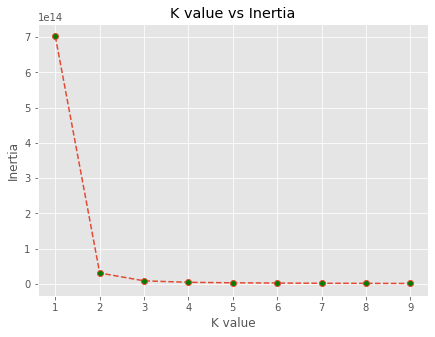

In [85]:
#Using the elbow method to find the optimum number of clusters

X = credit_D[credit_D.columns[1:]]

inertia_list = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state = RANDOM_STATE)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
    
# Show graph elbow method
plt.figure(figsize=(7,5))
plt.plot(range(1,10),inertia_list,marker='o',markerfacecolor='green',linestyle='dashed')
plt.title('K value vs Inertia')
plt.xlabel('K value')
plt.ylabel('Inertia')

In [86]:
# Declaring Model
model = KMeans(n_clusters=2, random_state = RANDOM_STATE)

# Fitting Modelsg
labels = model.fit_predict(X)
data = pd.DataFrame(labels)

In [87]:
data.value_counts()

0    4706
1     663
dtype: int64

In [88]:
credit_D['Daily_Balance'].describe()

count     5369.000000
mean      7029.858862
std       3906.014140
min        211.176471
25%       3868.316461
50%       6388.536013
75%       9348.393120
max      26297.662332
Name: Daily_Balance, dtype: float64

* The above model shows customers are divided into **2** clusters
* We will define the target variable based on these **2** clusters (**12%** in cluster **1** and **88%** in cluster **0**)

* We can see that **75%** of customers have an average daily balance not less than **9,348 dollars** 
* So we take the **80%** percentile at roughly **11,000 dollas** & use it as the cutoff point to help define the target variable.
* We will define a Creditworthy Person as someone who has an average daily balance of at least **11,000 dollas** 
* And loan status other than **B(in default)** or **D(in debt)**

In [89]:
credit_data = credit_D.copy()

credit_data["Daily_Balance"] = credit_D["Daily_Balance"].map(lambda val: 1 if val < 11000 else 0)

credit_data['CreditWorthy'] = credit_data["Daily_Balance"] + credit_data["Loan Status B"] + credit_data["Loan Status D"]
# if Daily_Balance + Loan Status B + Loan Status D is equal to 0 then, CreditWorthy = 1
credit_data['CreditWorthy'] = credit_data['CreditWorthy'].map(lambda val: 1 if val == 0 else 0)

credit_data['CreditWorthy'].value_counts()

0    4527
1     842
Name: CreditWorthy, dtype: int64

In [91]:
# We have to drop the Daily_Balance & Loan Status B & D columns because they are dependant variables

credit_data.drop(['Daily_Balance','Loan Status B','Loan Status D'], axis = 1, inplace=True)

## EXPLORATORY DATA ANALYSIS <a class="anchor" id="EXPLORATORYDATAANALYSIS"></a>

In [92]:
credit_data.head()

,ClientID,Age,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,DurationinMonths,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status C,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard,Adult,Middle- Aged,Senior,Youth,CreditWorthy
0,1,28,46,5,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,0.0,0.0,0.0,0.0,2452.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0,0,0,1,0,0,0,0
1,2,53,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,24.0,1821.0,0.0,0.0,7266.0,0.0,0.0,3372.7,0.0,0,1,0,0,1,0,0,0,0,1,0,0,0
2,3,58,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,24.0,1821.0,0.0,0.0,7266.0,0.0,0.0,3372.7,0.0,1,1,0,0,1,0,0,0,0,1,0,0,0
3,4,42,29,1,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,0.0,0.0,0.0,327.0,1135.0,3539.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,0,0
4,5,38,29,1,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,0.0,0.0,0.0,327.0,1135.0,3539.0,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,1,0,0,0


In [93]:
credit_data.describe()

,ClientID,Age,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,DurationinMonths,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status C,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard,Adult,Middle- Aged,Senior,Youth,CreditWorthy
count,5369.000000,5369.000000,5369.000000,5369.000000,5.369000e+03,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000
mean,3359.011920,44.801639,35.254796,3.505122,2.692806e+05,5.517974,69.240045,9510.758614,2.912486,3.490942,121.191097,14665.696405,16352.240082,17201.785146,142.669982,5.585398,127.374371,2.269678,618.408456,3172.464891,155.487614,163.452822,694.782380,77.716148,0.492643,0.048054,0.091823,0.845968,0.833861,0.122742,0.016390,0.027007,0.197802,0.500466,0.152356,0.149376,0.156826
std,2832.911984,17.282283,21.801799,2.255235,3.590500e+05,2.940686,19.896870,1330.686689,1.889014,2.134924,23.106521,26977.698874,31330.146616,13364.259425,147.589768,14.722325,363.296790,8.866517,1519.700512,3028.367320,740.985600,663.172252,1820.400626,239.195706,0.499992,0.213900,0.288803,0.361013,0.372240,0.328171,0.126983,0.162119,0.398379,0.500046,0.359399,0.356492,0.363671
min,1.000000,11.000000,0.000000,0.000000,4.282100e+04,1.000000,33.900000,8110.000000,0.290000,0.430000,81.000000,818.000000,888.000000,906.976744,8.206003,0.000000,0.000000,-54.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1418.000000,30.000000,17.000000,2.000000,8.888400e+04,4.000000,52.700000,8547.000000,1.600000,1.960000,105.000000,2159.000000,2252.000000,5974.924342,46.723646,0.000000,0.000000,0.000000,0.000000,308.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2839.000000,44.000000,33.000000,4.000000,1.219470e+05,6.000000,63.100000,8980.000000,2.770000,3.470000,116.000000,3729.000000,3839.000000,14196.491333,92.475021,0.000000,0.000000,0.000000,0.000000,2556.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,4257.000000,58.000000,53.000000,6.000000,2.261220e+05,8.000000,85.600000,9897.000000,4.010000,4.790000,131.000000,6604.000000,6295.000000,24258.418514,183.295521,0.000000,0.000000,0.000000,143.000000,4673.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,13998.000000,87.000000,76.000000,7.000000,1.204953e+06,11.000000,100.000000,12541.000000,7.340000,9.400000,167.000000,85677.000000,99107.000000,74575.716942,1283.279446,60.000000,2005.000000,59.233333,12925.000000,14882.000000,12504.000000,4975.200000,9910.000000,1880.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


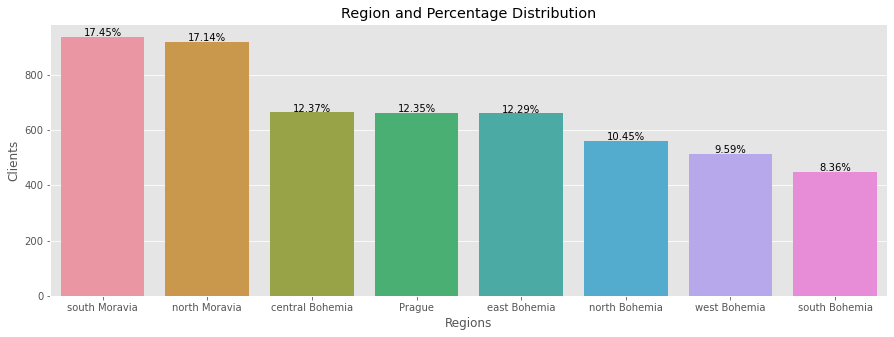

In [94]:
# Visualization for RegionName Column

RegionName = Credit_data['RegionName'].value_counts()

total = len(Credit_data)
plt.figure(figsize=(15,5))
ax = sns.barplot(RegionName.index, RegionName.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")

plt.title("Region and Percentage Distribution")
plt.xlabel("Regions")
plt.ylabel("Clients")
plt.show()

<AxesSubplot:ylabel='RegionName'>

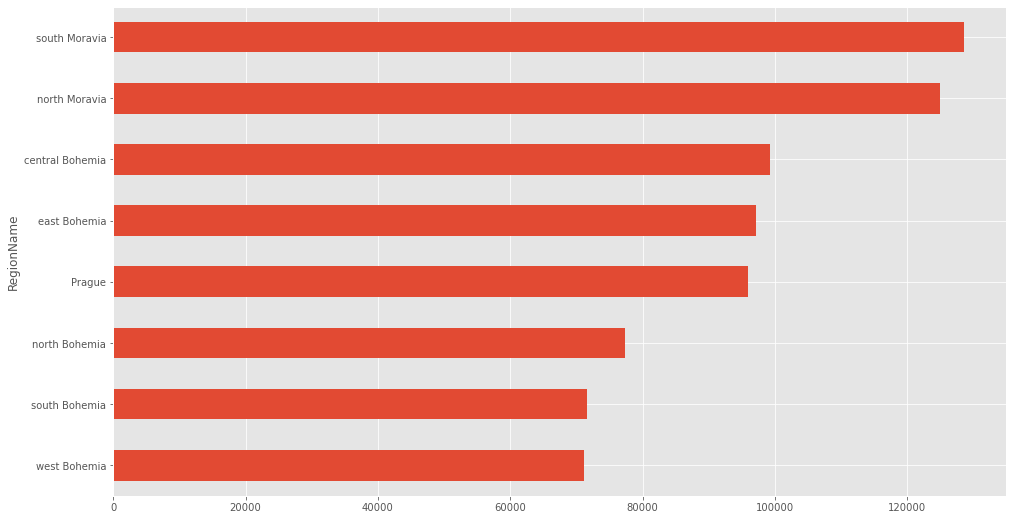

In [95]:
# Visualization for Average Monthly Spending Column

AvMS = Credit_data.groupby("RegionName")["Avg_Monthly_Spending"].sum().sort_values()
AvMS.plot(kind="barh", fontsize=10)

<AxesSubplot:ylabel='RegionName'>

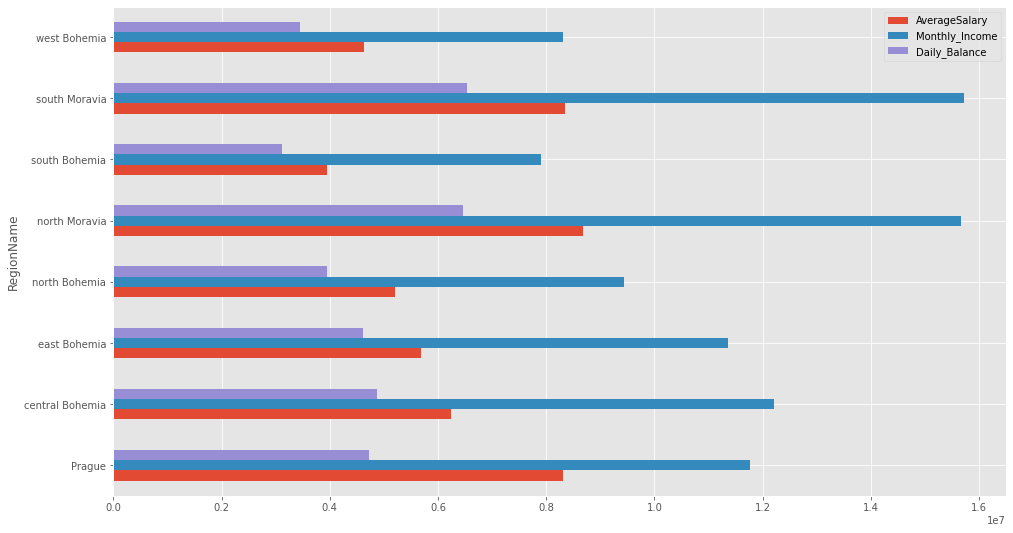

In [96]:
# Visualization for Average Salary, Monthly Income, Daily Balance Columns

RGN = Credit_data.groupby(['RegionName']).agg({'AverageSalary':sum,
                                               'Monthly_Income':sum,
                                               'Daily_Balance':sum}).reset_index()

RGN.plot(x= "RegionName", y=["AverageSalary", "Monthly_Income", "Daily_Balance"], kind="barh")

<AxesSubplot:ylabel='RegionName'>

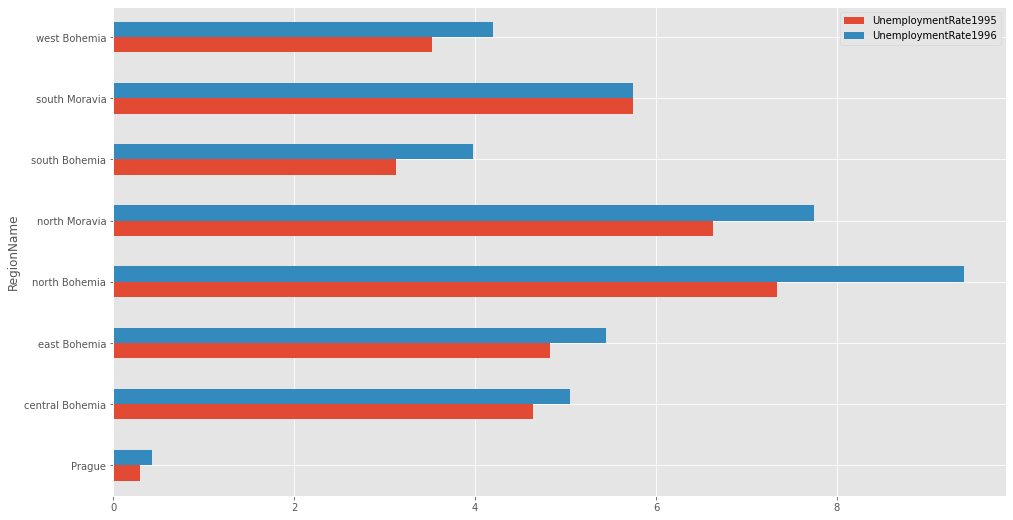

In [97]:
# Visualization for Unemployment Rate 95 & 96 by Region

UPCR = Credit_data.groupby(['RegionName']).agg({'UnemploymentRate1995':max,
                                                'UnemploymentRate1996':max}).reset_index()

UPCR.plot(x= "RegionName", y=["UnemploymentRate1995", "UnemploymentRate1996"], kind="barh")


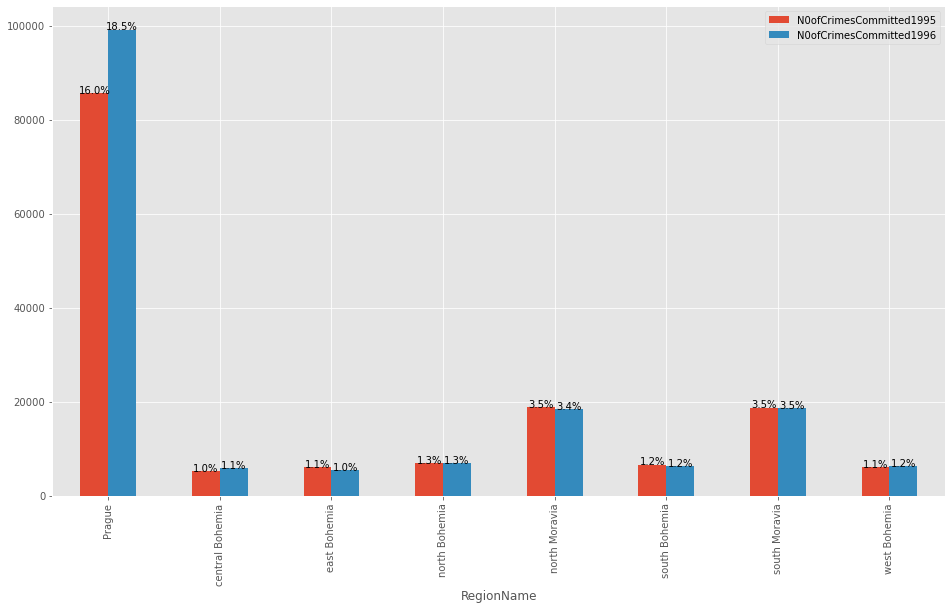

In [98]:
# Visualization for N0. of Crimes Committed 95 & 96 by Region

CR = Credit_data.groupby(['RegionName']).agg({'N0ofCrimesCommitted1995':max,
                                              'N0ofCrimesCommitted1996':max}).reset_index()

CR=CR.plot(x= "RegionName", y=["N0ofCrimesCommitted1995", "N0ofCrimesCommitted1996"], kind="bar")
for p in CR.patches:
    height = p.get_height()
    CR.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*1 :1.1f}%",
            ha="center")

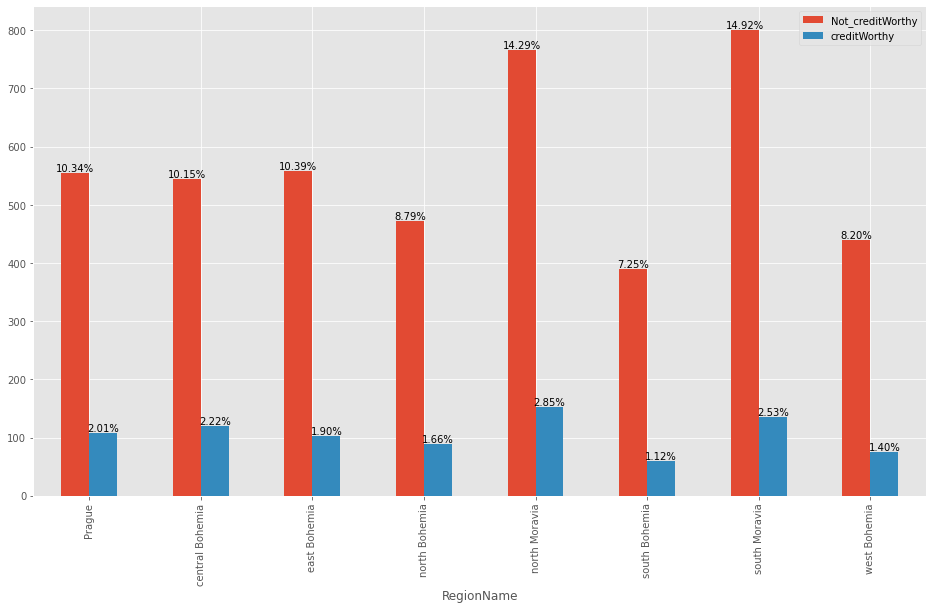

In [99]:
RGCD = pd.merge(Credit_data[['ClientID', 'RegionName']], credit_data[['ClientID','CreditWorthy']], on=['ClientID'])

RGCD['Not_creditWorthy'] = RGCD["CreditWorthy"]==0
RGCD['creditWorthy'] = RGCD["CreditWorthy"]==1

RGCD = RGCD.groupby(['RegionName']).agg({'Not_creditWorthy':sum,
                                         'creditWorthy':sum}).reset_index()

RGCD = RGCD.plot(x= "RegionName", y=['Not_creditWorthy', 'creditWorthy'], kind="bar")
for p in RGCD.patches:
    height = p.get_height()
    RGCD.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")

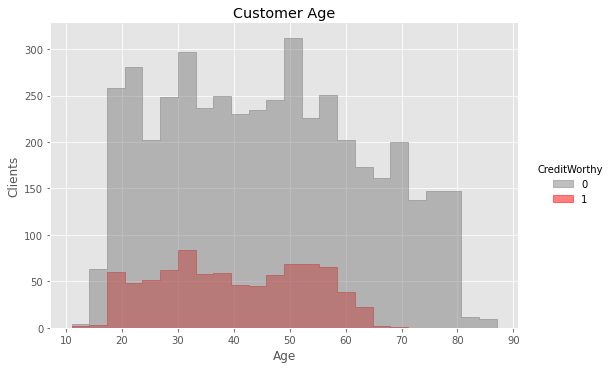

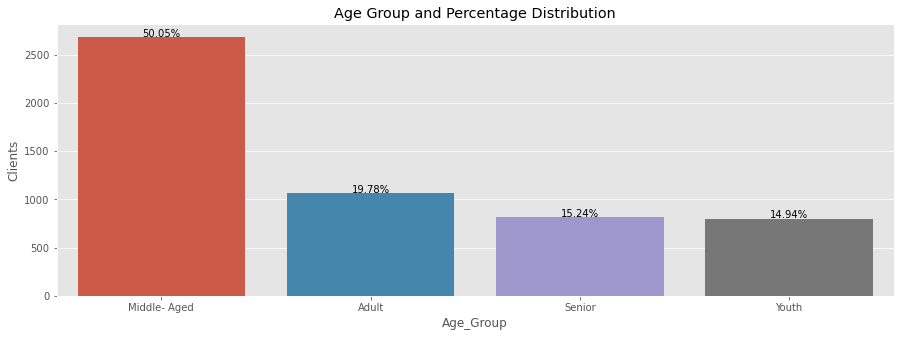

In [100]:
# Visualization for Clients Age Group

sns.displot(credit_data, x="Age", hue="CreditWorthy", element="step", alpha=0.5, height=5, aspect=1.5, palette=["grey", "r"])
plt.title('Customer Age')
plt.xlabel('Age')
plt.ylabel('Clients')

plt.show()


Age_Group = Credit_data['Age Group'].value_counts()

total = len(Credit_data)
plt.figure(figsize=(15,5))
ax = sns.barplot(Age_Group.index, Age_Group.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")

plt.title("Age Group and Percentage Distribution")
plt.xlabel("Age_Group")
plt.ylabel("Clients")
plt.show()

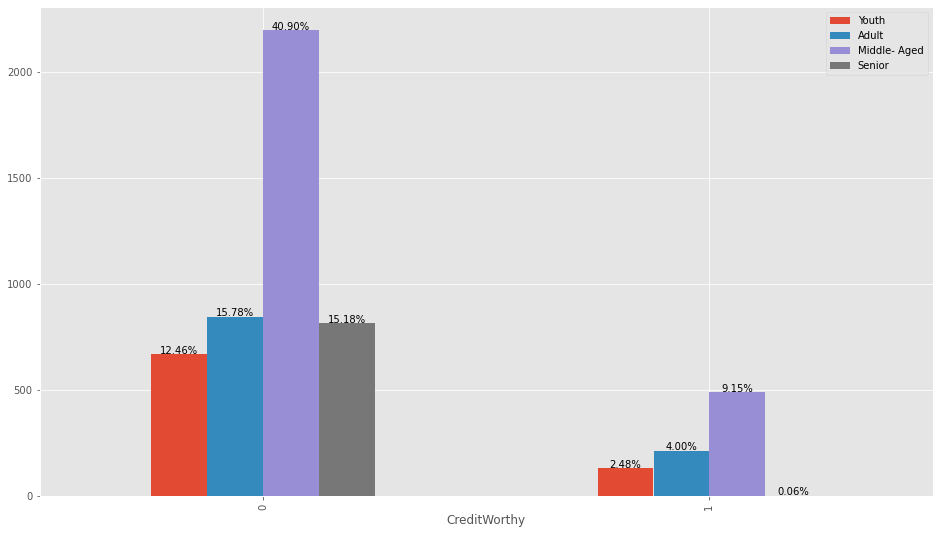

In [101]:
AgeGr = credit_data.groupby(['CreditWorthy']).agg({'Youth':sum,
                                                   'Adult':sum,
                                                   'Middle- Aged':sum,
                                                   'Senior':sum}).reset_index()

AgeGrx = AgeGr.plot(x= "CreditWorthy", y=["Youth", "Adult", "Middle- Aged", "Senior"], kind="bar")
for p in AgeGrx.patches:
    height = p.get_height()
    AgeGrx.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")

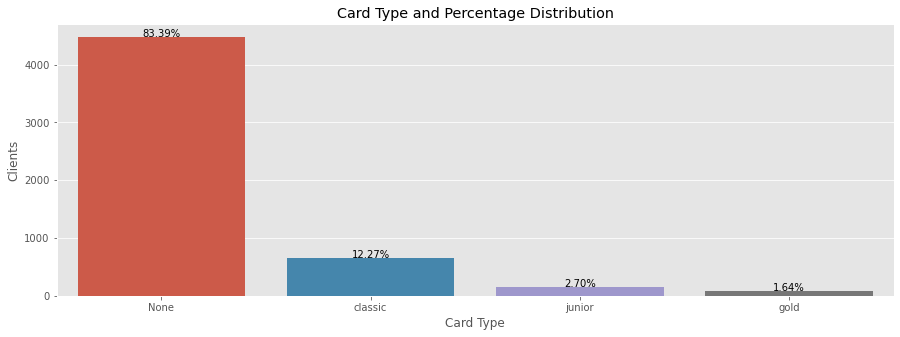

In [102]:
# Visualization for Credit Card Type

Card_Type = credit_['Card_Type'].value_counts()

total = len(credit_)
plt.figure(figsize=(15,5))
ax = sns.barplot(Card_Type.index, Card_Type.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")

plt.title("Card Type and Percentage Distribution")
plt.xlabel("Card Type")
plt.ylabel("Clients")
plt.show()

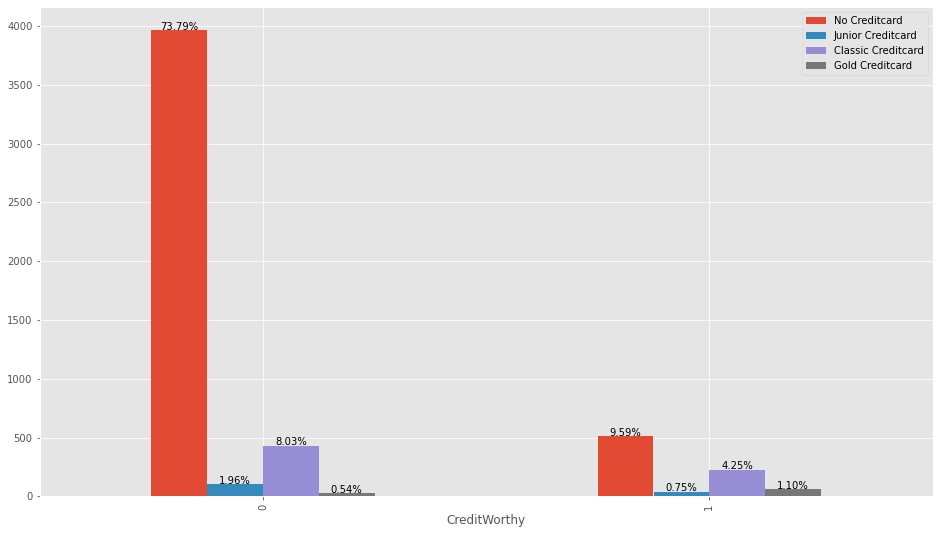

In [103]:
Crcd = credit_data.groupby(['CreditWorthy']).agg({'No Creditcard':sum,
                                                   'Junior Creditcard':sum,
                                                   'Classic Creditcard':sum,
                                                   'Gold Creditcard':sum}).reset_index()

Crcd = Crcd.plot(x= "CreditWorthy", y=["No Creditcard", "Junior Creditcard", "Classic Creditcard", "Gold Creditcard"], kind="bar")
for p in Crcd.patches:
    height = p.get_height()
    Crcd.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")

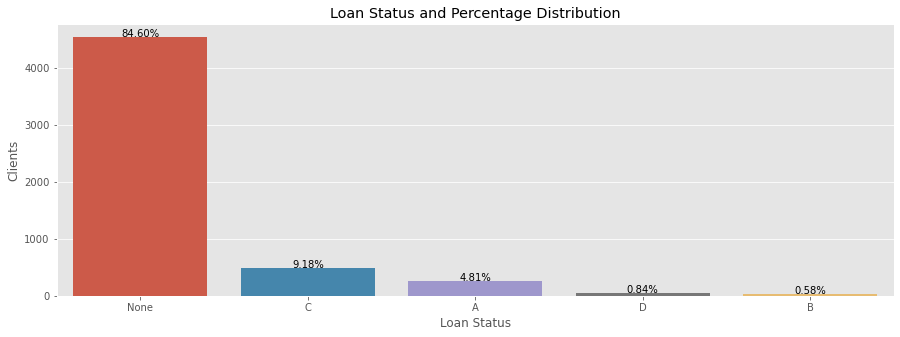

In [104]:
# Visualization for Loan Status

Loan_Status_Cat = credit_['Loan_Status_Cat'].value_counts()

total = len(credit_)
plt.figure(figsize=(15,5))
ax = sns.barplot(Loan_Status_Cat.index, Loan_Status_Cat.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")

plt.title("Loan Status and Percentage Distribution")
plt.xlabel("Loan Status")
plt.ylabel("Clients")
plt.show()

* The above shows that less than **2%** of clients are in category **B** and **D** while, **85%** have no loan history, **5%** and **9%** of clients are not in arrears or in default. So most customers who were given a loan are likely to be good customers.

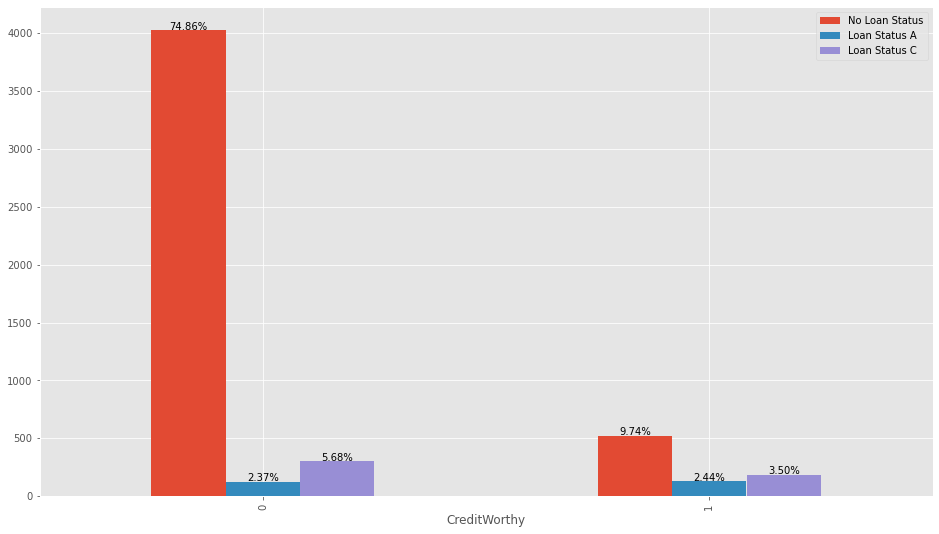

In [105]:
LnSt = credit_data.groupby(['CreditWorthy']).agg({'No Loan Status':sum,
                                                   'Loan Status A':sum,
                                                   'Loan Status C':sum}).reset_index()

LnSt = LnSt.plot(x= "CreditWorthy", y=["No Loan Status", "Loan Status A", "Loan Status C"], kind="bar")
for p in LnSt.patches:
    height = p.get_height()
    LnSt.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")

* Only **10%** out of the **85%** of clients with no loan history has a balance of **11,000** dollars or more are **CreditWorthy**.

## FEATURE SELECTION AND ENGINEERING <a class="anchor" id="FEATURESELECTIONANDENGINEERING"></a>

### Step 1: Filter Method <a class="anchor" id="Step1:FilterMethod_6_1"></a>

In [106]:
from sklearn.model_selection import train_test_split

feature_cols = credit_data.columns[1:].drop(['CreditWorthy'])

feature_cols

Index(['Age', 'DistrictName', 'RegionName', 'N0ofInhabitants', 'N0ofCities',
       'RatioOfUrbanInhabitants', 'AverageSalary', 'UnemploymentRate1995',
       'UnemploymentRate1996', 'EntrepreneursPer1000inhabitants',
       'N0ofCrimesCommitted1995', 'N0ofCrimesCommitted1996', 'Monthly_Income',
       'Avg_Monthly_Spending', 'DurationinMonths', 'Days_Loan_Issued',
       'Months_Loan_Left', 'Unknown', 'Household (H)',
       'Insurance Payment (IP)', 'Leasing (L)', 'Loan Payment (LP)',
       'Days_Card_Issued', 'Female', 'Loan Status A', 'Loan Status C',
       'No Loan Status', 'No Creditcard', 'Classic Creditcard',
       'Gold Creditcard', 'Junior Creditcard', 'Adult', 'Middle- Aged',
       'Senior', 'Youth'],
      dtype='object')

In [107]:
X = credit_data[feature_cols]
y = credit_data['CreditWorthy']

In [108]:
importances = X.apply(lambda x: x.corr(y))
indices = np.argsort(importances)
print(importances[indices])

No Loan Status                    -0.268607
No Creditcard                     -0.257487
Senior                            -0.178565
Age                               -0.122857
RegionName                        -0.024602
N0ofCities                        -0.010301
Female                            -0.010046
RatioOfUrbanInhabitants            0.000327
UnemploymentRate1995               0.005262
N0ofCrimesCommitted1996            0.007215
N0ofInhabitants                    0.007343
N0ofCrimesCommitted1995            0.007365
AverageSalary                      0.009469
Youth                              0.010382
UnemploymentRate1996               0.011413
EntrepreneursPer1000inhabitants    0.015720
DistrictName                       0.033187
Junior Creditcard                  0.054537
Adult                              0.062299
Middle- Aged                       0.071306
Household (H)                      0.086639
Insurance Payment (IP)             0.128361
Months_Loan_Left                

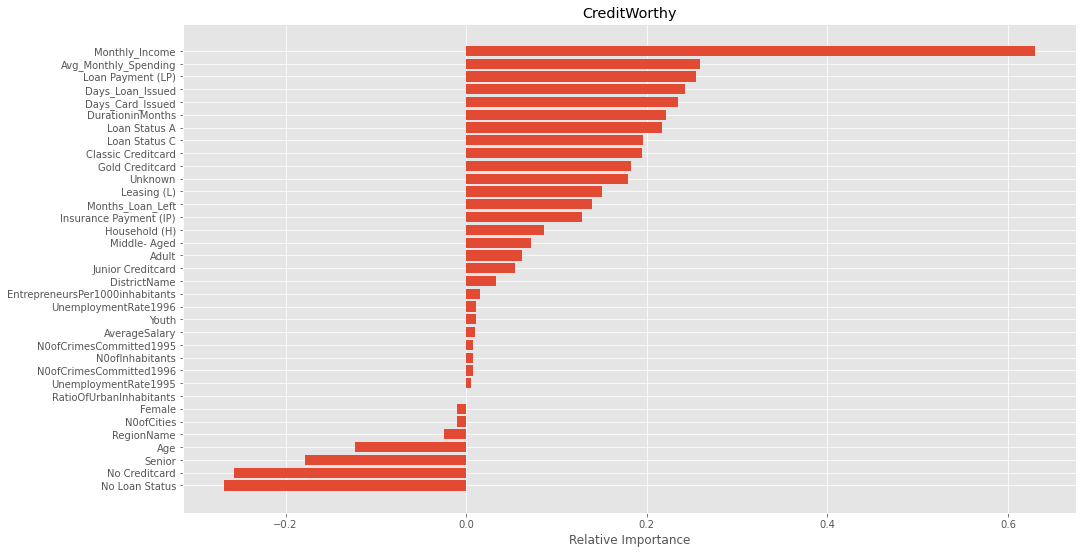

In [109]:
Names=feature_cols
plt.title('CreditWorthy')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [Names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [110]:
for i in range(0, 21):
    if np.abs(importances[i])>0.1:
        print(Names[i])

Age
Monthly_Income
Avg_Monthly_Spending
DurationinMonths
Days_Loan_Issued
Months_Loan_Left
Unknown
Insurance Payment (IP)
Leasing (L)


We want to keep features with only a high correlation with the target variable. This implies that the input feature has a high influence in predicting the target variable.
We set the threshold to the absolute value of **0.1**. We keep input features only if the correlation of the input feature with the target variable is greater than **0.1**

### Step 2 <a class="anchor" id="Step2_6_2"></a>

Identify input features that have a low correlation with other independent variables.

In [111]:
Names = ['Age', 'Monthly_Income', 'Avg_Monthly_Spending', 'DurationinMonths', 'Days_Loan_Issued', 'Months_Loan_Left',
         'Unknown', 'Insurance Payment (IP)', 'Leasing (L)']

In [112]:
X = credit_data[Names]

In [113]:
for i in range(0,len(X.columns)):
    for j in  range(0,len(X.columns)):
        if i!=j:
            corr_1=np.abs(X[X.columns[i]].corr(X[X.columns[j]]))
            if corr_1 <0.3:
                print( X.columns[i] , " Is not correlated  with ", X.columns[j])
            elif corr_1>0.75:
                print( X.columns[i] , " Is highly  correlated  with ", X.columns[j])

Age  Is not correlated  with  Monthly_Income
Age  Is not correlated  with  Avg_Monthly_Spending
Age  Is not correlated  with  DurationinMonths
Age  Is not correlated  with  Days_Loan_Issued
Age  Is not correlated  with  Months_Loan_Left
Age  Is not correlated  with  Unknown
Age  Is not correlated  with  Insurance Payment (IP)
Age  Is not correlated  with  Leasing (L)
Monthly_Income  Is not correlated  with  Age
Monthly_Income  Is not correlated  with  Months_Loan_Left
Monthly_Income  Is not correlated  with  Unknown
Monthly_Income  Is not correlated  with  Insurance Payment (IP)
Monthly_Income  Is not correlated  with  Leasing (L)
Avg_Monthly_Spending  Is not correlated  with  Age
Avg_Monthly_Spending  Is not correlated  with  DurationinMonths
Avg_Monthly_Spending  Is not correlated  with  Days_Loan_Issued
Avg_Monthly_Spending  Is not correlated  with  Months_Loan_Left
Avg_Monthly_Spending  Is not correlated  with  Unknown
Avg_Monthly_Spending  Is not correlated  with  Insurance Paymen

### Step 3 <a class="anchor" id="Step3_6_3"></a>
Find the information gain or mutual information of the independent variable with respect to a target variable.

In [114]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

X = credit_data[Names]

mi = mutual_info_regression(X, y)

<AxesSubplot:>

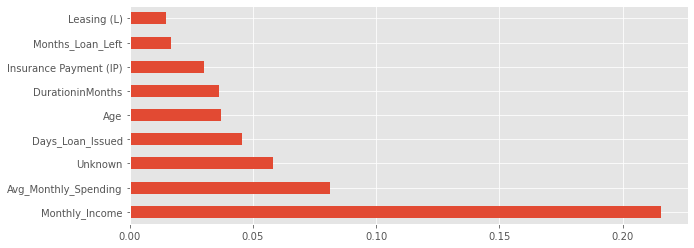

In [115]:
# Plotting the mutual information

mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.barh(figsize=(10, 4))

## UNSUPERVISED MACHINE LEARNING MODELLING <a class="anchor" id="UNSUPERVISEDMACHINELEARNINGMODELLING"></a>

### K-Means Clustering <a class="anchor" id="K-MeansClustering_7_1"></a>

In [116]:
# Declaring Model
Model = KMeans(n_clusters=2, random_state = RANDOM_STATE)

# Fitting Model
labels = Model.fit_predict(X)

# Create a DataFrame with labels and targets as columns: datF
datF = pd.DataFrame({'labels':labels, 'targets': y})

# Create crosstab: Ctab
Ctab = pd.crosstab(datF["labels"],datF["targets"])

# Display Ctab
print(Ctab)

targets     0    1
labels            
0        3503  117
1        1024  725


In [117]:
cust2=datF[datF["targets"]==1]
print('Number of customer =', len(cust2))
print('They are -', cust2["labels"].values)

Number of customer = 842
They are - [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0
 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1

**725** out of **842** Clients were predicted correctly to be **Credit Worthy**. Hence, it is a good model to identify the most suitable customers to be offered a Credit Card Product.

In [118]:
# Model Evaluation

from sklearn import metrics
metrics.silhouette_score(X, labels,
metric='euclidean')

0.5987296011557673

We got the Silhouette coefficient value as **0.5987296011557673**
It’s moving towards 1 so our Model is good

In [119]:
# Printing the Clients IDs who are CreditWorthy

CreditWorthy_Clients=credit_data[credit_data["CreditWorthy"]==1]
Not_CreditWorthy_Clients=credit_data[credit_data["CreditWorthy"]==0]

print('Number of customer =', len(CreditWorthy_Clients))
print('They are -', CreditWorthy_Clients["ClientID"].values)

Number of customer = 842
They are - [   31    38    39    41    42    51    55    60    76    77    78    79
    83    84    85    86    97   114   115   116   117   160   193   202
   210   211   215   218   226   238   254   255   264   289   317   321
   326   327   352   353   358   364   378   379   389   399   408   414
   415   439   441   445   446   458   464   471   478   489   497   498
   526   527   531   532   544   548   557   562   583   598   599   603
   608   626   679   680   686   687   713   714   750   762   774   778
   781   786   798   799   826   839   854   861   876   880   886   924
   927   928   929   940   980  1018  1020  1025  1039  1040  1066  1067
  1080  1102  1133  1134  1146  1157  1182  1194  1195  1204  1208  1209
  1213  1215  1220  1226  1227  1236  1239  1244  1246  1247  1271  1279
  1280  1281  1313  1314  1316  1317  1349  1350  1351  1353  1359  1360
  1370  1378  1379  1384  1388  1396  1408  1414  1449  1452  1453  1483
  1484  1492  1

In [120]:
CreditWorthy_Clients

,ClientID,Age,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,DurationinMonths,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status C,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard,Adult,Middle- Aged,Senior,Youth,CreditWorthy
30,31,36,15,4,228848,6,57.2,9893.0,4.09,4.72,96,5623,5887,50599.506772,258.213352,12.0,388.0,0.000000,1110.0,6817.0,164.0,0.0,2523.2,0.0,0,1,0,0,1,0,0,0,0,1,0,0,1
35,38,25,32,3,159617,9,85.2,9198.0,3.33,4.28,131,5796,6132,49455.534717,321.240472,0.0,0.0,0.000000,0.0,0.0,0.0,2480.2,0.0,0.0,1,0,0,1,1,0,0,0,1,0,0,0,1
36,39,30,15,4,228848,6,57.2,9893.0,4.09,4.72,96,5623,5887,52034.948153,236.516841,0.0,0.0,0.000000,0.0,10202.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,1,0,0,0,1
38,41,30,14,7,58400,6,52.4,8620.0,1.10,1.25,100,1089,1117,25686.565284,112.487786,0.0,0.0,0.000000,0.0,3892.0,0.0,0.0,0.0,1215.0,0,0,0,1,0,0,1,0,1,0,0,0,1
39,42,63,15,4,228848,6,57.2,9893.0,4.09,4.72,96,5623,5887,34122.824961,118.242008,0.0,0.0,0.000000,6070.0,502.0,0.0,1479.0,0.0,35.0,0,0,0,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5353,13803,51,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,48767.061960,365.788634,12.0,433.0,0.000000,229.0,9783.0,0.0,0.0,7440.5,0.0,0,1,0,0,1,0,0,0,0,1,0,0,1
5357,13886,44,12,2,105606,7,53.0,8254.0,2.79,3.76,97,2166,2325,20630.929493,56.794377,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,1,0,0,1
5358,13912,23,63,2,102609,6,52.0,8187.0,4.83,5.45,94,2123,2134,62971.678439,573.513452,60.0,39.0,58.700000,2784.0,3849.0,0.0,0.0,5290.8,0.0,0,0,1,0,1,0,0,0,0,0,0,1,1
5364,13955,53,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,45528.711787,210.110532,60.0,1159.0,21.366667,0.0,10886.0,0.0,0.0,6998.0,0.0,1,0,1,0,1,0,0,0,0,1,0,0,1


In [121]:
CreditWorthy_Clients.describe()

,ClientID,Age,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,DurationinMonths,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status C,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard,Adult,Middle- Aged,Senior,Youth,CreditWorthy
count,842.000000,842.000000,842.000000,842.000000,8.420000e+02,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.0
mean,4710.983373,39.878860,36.932304,3.376485,2.753931e+05,5.447743,69.255107,9539.971496,2.935534,3.547435,122.033254,15126.375297,16876.362233,36720.663015,231.078377,13.140143,331.092637,5.135194,1248.460808,3780.786223,376.009501,394.159620,1766.439667,207.681710,0.480998,0.155582,0.223278,0.621140,0.611639,0.270784,0.070071,0.047506,0.255344,0.583135,0.003563,0.157957,1.0
std,3770.858051,13.167161,22.076215,2.247380,3.646338e+05,2.937761,20.148593,1344.926022,1.906745,2.169358,23.506952,27412.191940,31836.017969,13029.652535,193.767800,20.043990,534.134624,11.879513,2056.152587,3735.169284,1100.707338,1057.292893,2578.618639,372.426744,0.499936,0.362674,0.416691,0.485391,0.487667,0.444629,0.255419,0.212845,0.436314,0.493333,0.059619,0.364918,0.0
min,31.000000,12.000000,0.000000,0.000000,4.282100e+04,1.000000,33.900000,8110.000000,0.290000,0.430000,81.000000,818.000000,888.000000,4705.218136,9.444552,0.000000,0.000000,-0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1963.000000,29.000000,17.000000,1.000000,8.876800e+04,4.000000,52.000000,8546.000000,1.600000,1.960000,107.000000,2159.000000,2252.000000,25017.002276,100.999537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,3601.500000,39.000000,36.000000,4.000000,1.219470e+05,6.000000,62.600000,8994.000000,2.800000,3.600000,117.000000,3736.000000,3839.000000,38735.744957,171.173875,0.000000,0.000000,0.000000,0.000000,3085.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0
75%,6194.750000,52.000000,55.000000,5.750000,2.261220e+05,7.000000,87.700000,10013.750000,4.090000,4.790000,132.000000,8991.250000,8624.000000,46636.702016,289.794993,24.000000,508.000000,0.000000,1806.750000,6164.000000,40.750000,0.000000,3478.125000,287.750000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0
max,13956.000000,68.000000,76.000000,7.000000,1.204953e+06,11.000000,100.000000,12541.000000,7.340000,9.400000,167.000000,85677.000000,99107.000000,74575.716942,1283.279446,60.000000,1999.000000,58.700000,12925.000000,14882.000000,9115.000000,4975.200000,9444.000000,1880.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [122]:
Not_CreditWorthy_Clients

,ClientID,Age,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,DurationinMonths,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status C,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard,Adult,Middle- Aged,Senior,Youth,CreditWorthy
0,1,28,46,5,70699,4,65.3,8968.0,2.83,3.35,131,1740,1910,4230.489840,28.739523,0.0,0.0,0.000000,0.0,2452.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0,0,0,1,0,0,0,0
1,2,53,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,24.0,1821.0,0.000000,0.0,7266.0,0.0,0.0,3372.7,0.0,0,1,0,0,1,0,0,0,0,1,0,0,0
2,3,58,17,0,1204953,1,100.0,12541.0,0.29,0.43,167,85677,99107,22451.548735,67.031546,24.0,1821.0,0.000000,0.0,7266.0,0.0,0.0,3372.7,0.0,1,1,0,0,1,0,0,0,0,1,0,0,0
3,4,42,29,1,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,0.0,0.0,0.000000,327.0,1135.0,3539.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,0,0
4,5,38,29,1,95616,6,51.4,9307.0,3.85,4.43,118,2616,3040,9578.911439,95.080400,0.0,0.0,0.000000,327.0,1135.0,3539.0,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5362,13924,46,4,6,387570,1,100.0,9897.0,1.60,1.96,140,18721,18696,26534.465649,290.452034,60.0,166.0,54.466667,0.0,0.0,0.0,0.0,4674.0,0.0,1,0,1,0,1,0,0,0,0,1,0,0,0
5363,13931,56,36,1,112065,8,69.4,11277.0,1.25,1.44,127,5179,4987,29947.457143,156.248830,0.0,0.0,0.000000,0.0,0.0,0.0,3286.7,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,0,0
5366,13968,30,67,6,117897,6,53.8,8814.0,4.76,5.74,107,2112,2059,29219.868557,101.336644,12.0,877.0,0.000000,254.0,4518.0,0.0,0.0,4502.3,1297.0,0,1,0,0,0,1,0,0,1,0,0,0,0
5367,13971,36,6,4,106054,6,63.1,8110.0,5.77,6.55,109,3244,3079,17485.622658,62.741509,24.0,734.0,0.000000,185.0,4780.0,330.0,0.0,5392.0,0.0,1,1,0,0,1,0,0,0,0,1,0,0,0


In [123]:
Not_CreditWorthy_Clients.describe()

,ClientID,Age,DistrictName,RegionName,N0ofInhabitants,N0ofCities,RatioOfUrbanInhabitants,AverageSalary,UnemploymentRate1995,UnemploymentRate1996,EntrepreneursPer1000inhabitants,N0ofCrimesCommitted1995,N0ofCrimesCommitted1996,Monthly_Income,Avg_Monthly_Spending,DurationinMonths,Days_Loan_Issued,Months_Loan_Left,Unknown,Household (H),Insurance Payment (IP),Leasing (L),Loan Payment (LP),Days_Card_Issued,Female,Loan Status A,Loan Status C,No Loan Status,No Creditcard,Classic Creditcard,Gold Creditcard,Junior Creditcard,Adult,Middle- Aged,Senior,Youth,CreditWorthy
count,4527.000000,4527.000000,4527.000000,4527.000000,4.527000e+03,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.0
mean,3107.551800,45.717252,34.942788,3.529048,2.681437e+05,5.531036,69.237243,9505.325160,2.908200,3.480435,121.034460,14580.012370,16254.755909,13571.368719,126.226450,4.180252,89.483764,1.736706,501.221780,3059.320080,114.471615,120.542478,495.459333,53.543185,0.494809,0.028054,0.067374,0.887784,0.875193,0.095207,0.006406,0.023194,0.187100,0.485089,0.180031,0.147780,0.0
std,2544.197141,17.795495,21.738565,2.256132,3.580311e+05,2.941370,19.851946,1328.100389,1.885879,2.128535,23.030512,26898.308914,31237.746704,9809.372468,130.896861,13.031632,307.194846,8.075017,1366.004945,2864.105494,644.475984,549.686348,1562.506880,195.854209,0.500028,0.165145,0.250695,0.315666,0.330536,0.293532,0.079790,0.150536,0.390035,0.499833,0.384256,0.354921,0.0
min,1.000000,11.000000,0.000000,0.000000,4.282100e+04,1.000000,33.900000,8110.000000,0.290000,0.430000,81.000000,818.000000,888.000000,906.976744,8.206003,0.000000,0.000000,-54.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1335.500000,30.000000,17.000000,2.000000,8.888400e+04,4.000000,52.700000,8547.000000,1.600000,1.960000,105.000000,2159.000000,2252.000000,5460.736520,41.231201,0.000000,0.000000,0.000000,0.000000,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2720.000000,45.000000,32.000000,4.000000,1.219470e+05,6.000000,63.100000,8980.000000,2.770000,3.470000,116.000000,3729.000000,3839.000000,10614.831025,80.541337,0.000000,0.000000,0.000000,0.000000,2474.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,4086.500000,59.000000,53.000000,6.000000,2.261220e+05,8.000000,85.600000,9897.000000,4.010000,4.790000,131.000000,6604.000000,6295.000000,20429.009143,161.087077,0.000000,0.000000,0.000000,0.000000,4335.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
max,13998.000000,87.000000,76.000000,7.000000,1.204953e+06,11.000000,100.000000,12541.000000,7.340000,9.400000,167.000000,85677.000000,99107.000000,53406.308743,1270.876132,60.000000,2005.000000,59.233333,11766.000000,14811.000000,12504.000000,4896.500000,9910.000000,1807.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
